# 0.0 IMPORTS

In [176]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import matplotlib.gridspec as gridspec
import random
import warnings
import pickle

from tabulate import tabulate
from IPython.display import Image
from IPython.core.display import HTML
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
import xgboost as xgb


In [320]:
pip list

Package                           Version
--------------------------------- ----------
appnope                           0.1.0
attrs                             19.3.0
backcall                          0.1.0
bleach                            3.1.0
Boruta                            0.3
certifi                           2019.11.28
chardet                           3.0.4
Click                             7.0
cycler                            0.10.0
Cython                            0.29.28
decorator                         4.4.1
defusedxml                        0.6.0
docopt                            0.6.2
entrypoints                       0.3
Flask                             1.1.1
idna                              2.8
importlib-metadata                0.23
inflection                        0.3.1
ipykernel                         5.1.3
ipython                           7.9.0
ipython-genutils                  0.2.0
ipywidgets                        7.5.1
itsdangerous                     

## 0.1 Helper Functions

In [226]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 14]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()

    
#Cramer's V

def cramer(x,y):
    cm = pd.crosstab(x,y).values
    
    chi2 = ss.chi2_contingency(cm)[0]
    
    n = cm.sum()
    
    r,k = cm.shape
    
    v = np.sqrt((chi2/n) / (min(k-1,r-1)))
    
    phi2 = chi2/n
    
    phi2corr = max(0,(phi2 - ((k-1)*(r-1))/(n-1)))
    
    kcorr = k - (k-1)**2/(n-1)
    
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1,rcorr-1)))

#ERROR - MAE, MAPE, RMSE

def mean_absolute_percentual_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))
    
def ml_error(name_model,y,yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentual_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    return pd.DataFrame({
            'Name_Model': name_model,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },index = [0])


#CROSS VALIDATION FUNCTION

def cross_validation(xtraining,model,name_model,kfold):
    model_error = pd.DataFrame()
    for k in (range(1,kfold+1)):
        print ('\nKFold Number: {}'.format( k ) )
        #defining date
        start_validation = xtraining['date'].max() - datetime.timedelta(days=k*6*7)
        end_validation = xtraining['date'].max() - datetime.timedelta(days=(k-1)*6*7)
        
        #filtering dataset
        validation = xtraining[(xtraining['date']>start_validation) & (xtraining['date']<=end_validation)]
        training = xtraining[xtraining['date']<start_validation]
        
        #training and validation
        
        x_training = training.drop(['date','sales'],axis=1)
        y_training = training['sales']
        
        x_validation = validation.drop(['date','sales'],axis=1)
        y_validation = validation['sales']
        
        #model
        ml_model = model.fit(x_training,y_training)
    
        #prediction
        yhat = ml_model.predict(x_validation)
    
        #performance
        #model_error = model_error.append(ml_error(name_model,np.expm1(y_validation),np.expm1(yhat)))
        model_error = pd.concat([model_error,ml_error(name_model,np.expm1(y_validation),np.expm1(yhat))],axis=0)
    
    real_error = pd.DataFrame({
        'Name_Model': name_model,
        'MAE CV':str((np.round((model_error['MAE'].mean()),2)))+ '+/-' +str((np.round((model_error['MAE'].std()),2))),
        'MAPE CV':str((np.round((model_error['MAPE'].mean()),2)))+ '+/-' +str((np.round((model_error['MAPE'].std()),2))),
        'RMSE CV':str((np.round((model_error['RMSE'].mean()),2)))+ '+/-' +str((np.round((model_error['RMSE'].std()),2)))
    }, index = [0])

    return real_error

In [62]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/brunnaneri/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loading Data

In [3]:
df_raw_sale = pd.read_csv('data/train.csv', low_memory = False)
df_raw_store = pd.read_csv('data/store.csv',low_memory = False)

In [4]:
df_raw = pd.merge(df_raw_sale,df_raw_store, how='left',on='Store')

# 0.3 Sumary Data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 1.0 PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [15]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [16]:
old_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
               'Assortment',     'CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 
               'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

#Renomeando as colunas para o estilo snake_case
snake_case = lambda x : inflection.underscore(x)

new_columns = list(map(snake_case,old_columns))

#Rename Columns
df1.columns = new_columns


## 1.2 Data Dimensions

In [17]:
df1.shape

(1017209, 18)

In [18]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [19]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [20]:
#date to datetime

df1['date'] =pd.to_datetime(df1['date'])

In [21]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [22]:
#Verificando a presença de NA's nas colunas
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA


In [ ]:
#Nesta etapa se fez o preenchimento dos NA's considerando algumas premissas do negócio e assumindo características intrísecas ao problema de negócio.

#A necessidade do preenchimento/substituição se dá (quando cabe) pela importância de se manter os dados para que suas outras features possam ser exploradas.

In [23]:
df1['competition_distance'].max()

75860.0

In [24]:
#competition_distance   - NA's preenchidos/substitiudos por 200000 (valor muito maior que o máximo existente)
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month    

df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)

#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)
                       
#promo2_since_week    
df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)

#promo2_since_year               
df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)

#promo_interval                  
df1['promo_interval'].fillna(0,inplace=True)
    
    #aproveitando essa informação para saber se esses meses com promo2 influenciaram no aumento das vendas

dic_month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
df1['month_of_date'] = df1['date'].dt.month.map(dic_month)

df1['is_promo2'] = df1[['promo_interval','month_of_date']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_of_date'] in x['promo_interval'].split(',') else 0, axis =1)

## 1.6 Change Types

In [25]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [26]:
num_attributes = df1.select_dtypes(include=['int64','float64'])

In [27]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open', 'promo',
       'school_holiday', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2'],
      dtype='object')

In [41]:
num_attributes = num_attributes.drop(['promo','school_holiday','promo2','is_promo2'],axis=1)

In [44]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'customers', 'open',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2_since_week',
       'promo2_since_year'],
      dtype='object')

In [42]:
cat_attributes = df1.drop(num_attributes.columns,axis=1)

In [43]:
cat_attributes.columns

Index(['date', 'promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'promo2', 'promo_interval', 'month_of_date', 'is_promo2'],
      dtype='object')

### 1.7.1 Numerical Attributes

In [45]:
#Métricas de Tendência Central

tc1 = pd.DataFrame(num_attributes.mean())
tc2 = pd.DataFrame(num_attributes.median())

#Métricas de Dispersão

dp1 = pd.DataFrame(num_attributes.std())
dp2 = pd.DataFrame(num_attributes.min())
dp3 = pd.DataFrame(num_attributes.max())
dp4 = pd.DataFrame(num_attributes.skew())
dp5 = pd.DataFrame(num_attributes.kurtosis())
dp6 = pd.DataFrame(num_attributes.apply(lambda x: x.max()- x.min()))



In [46]:
#Unindo as métricas
m = pd.concat([tc1,tc2,dp2,dp3,dp6,dp1,dp4,dp5],axis=1,sort='True').reset_index()
m.columns = ['attributes','media','media','min','max','range','std','skew','kurtosis']

<ipython-input-46-f5421be54d99>:2: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  m = pd.concat([tc1,tc2,dp2,dp3,dp6,dp1,dp4,dp5],axis=1,sort='True').reset_index()


In [47]:
m

,attributes,media,media,min,max,range,std,skew,kurtosis
0,competition_distance,5935.442677,2330.0,20.0,200000.0,199980.0,12547.652996,10.242344,147.789712
1,competition_open_since_month,6.786849,7.0,1.0,12.0,11.0,3.311087,-0.042076,-1.232607
2,competition_open_since_year,2010.324840,2012.0,1900.0,2015.0,115.0,5.515593,-7.235657,124.071304
3,customers,633.145946,609.0,0.0,7388.0,7388.0,464.411734,1.598650,7.091773
4,day_of_week,3.998341,4.0,1.0,7.0,6.0,1.997391,0.001593,-1.246873
5,open,0.830107,1.0,0.0,1.0,1.0,0.375539,-1.758045,1.090723
6,promo2_since_week,23.619033,22.0,1.0,52.0,51.0,14.310064,0.178723,-1.184046
7,promo2_since_year,2012.793297,2013.0,2009.0,2015.0,6.0,1.662658,-0.784436,-0.210075
8,sales,5773.818972,5744.0,0.0,41551.0,41551.0,3849.926175,0.641460,1.778375
9,store,558.429727,558.0,1.0,1115.0,1114.0,321.908651,-0.000955,-1.200524


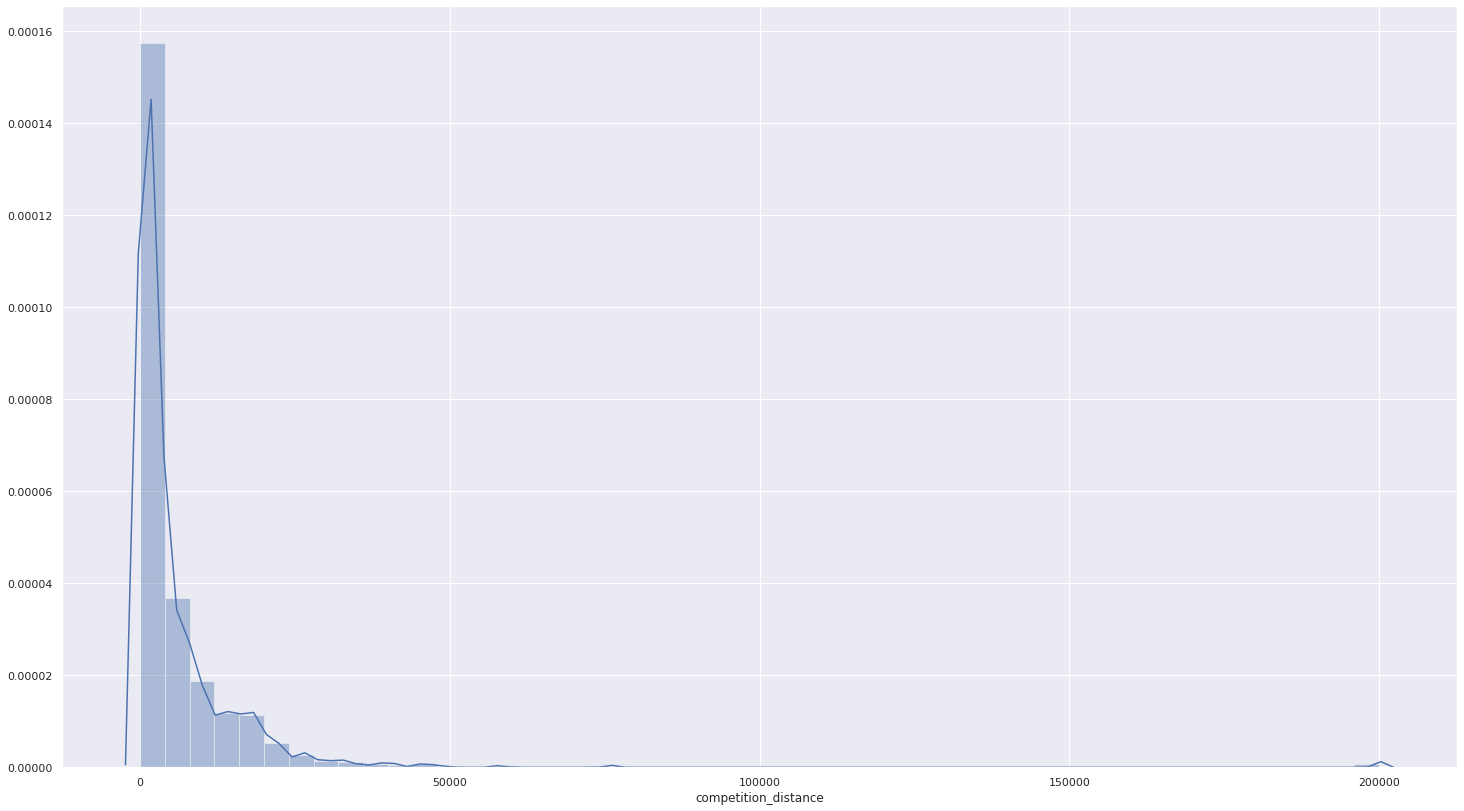

In [48]:
#Gráfico de distribuição da feature 'competition_distance'
sns.distplot(df1['competition_distance'])

Como foi obersavado no resultado do cálculo das métricas, o elevado valor da kurtosis na feature 'competition since' pôde ser verificado no gráfico de distribuição plotado acima.

### 1.7.2 Categorical Attributes

In [51]:
cat_attributes.columns

Index(['date', 'promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'promo2', 'promo_interval', 'month_of_date', 'is_promo2'],
      dtype='object')

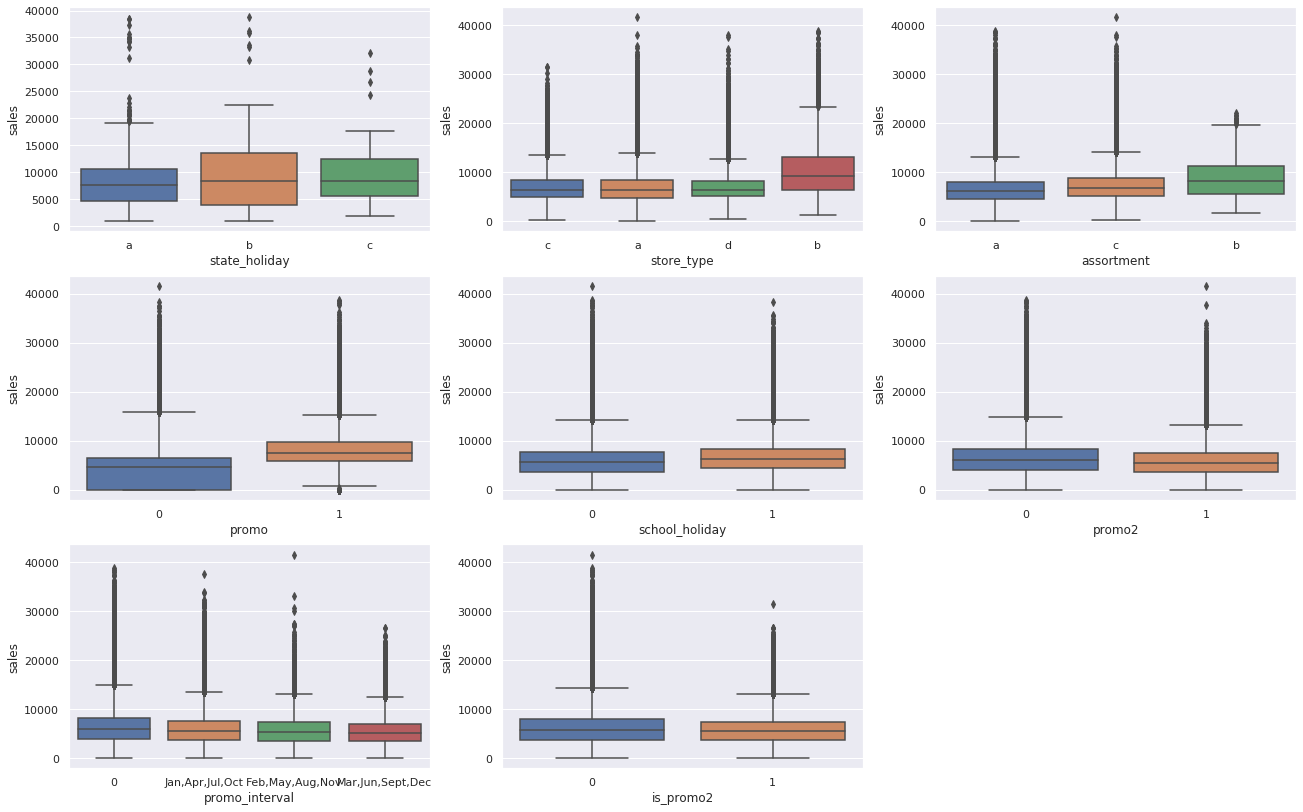

In [58]:
plt.figure(figsize=(22,14))

#filter in state_holiday to plot
aux_plot_1 = df1.loc[(df1['state_holiday']!='0') & (df1['sales']>0) ]
plt.subplot(3,3,1)
sns.boxplot( x = "state_holiday", y ="sales",data = aux_plot_1)

#filter in store_type to plot

aux_plot_2 = df1.loc[(df1['store_type']!='0') & (df1['sales']>0) ]
plt.subplot(3,3,2)
sns.boxplot( x = "store_type", y ="sales",data = aux_plot_2)

aux_plot_3 = df1.loc[(df1['assortment']!='0') & (df1['sales']>0) ]
#filter in assortment to plot
plt.subplot(3,3,3)
sns.boxplot( x = "assortment", y ="sales",data = aux_plot_3)

#promo
plt.subplot(3,3,4)
sns.boxplot( x = "promo", y ="sales",data = df1)

#school_holiday
plt.subplot(3,3,5)
sns.boxplot( x = "school_holiday", y ="sales",data = df1)

#promo2
plt.subplot(3,3,6)
sns.boxplot( x = "promo2", y ="sales",data = df1)

#promo interval
plt.subplot(3,3,7)
sns.boxplot( x = "promo_interval", y ="sales",data = df1)

#is_promo2
plt.subplot(3,3,8)
sns.boxplot( x = "is_promo2", y ="sales",data = df1)

- Com exceção do store_type 'b', o tipo da loja não parece influenciar tanto no quanto se vende.
- As lojas que participam da promoção regular ('promo') vendem mais.
- A participação na promoção extendida 'promo2' não parece influenciar no quanto se vende.

# 2.0 PASSO 02 - FEATURE ENGINEERING

In [44]:
df2 = df1.copy()

## 2.1 Mapa Mental de Hipóteses

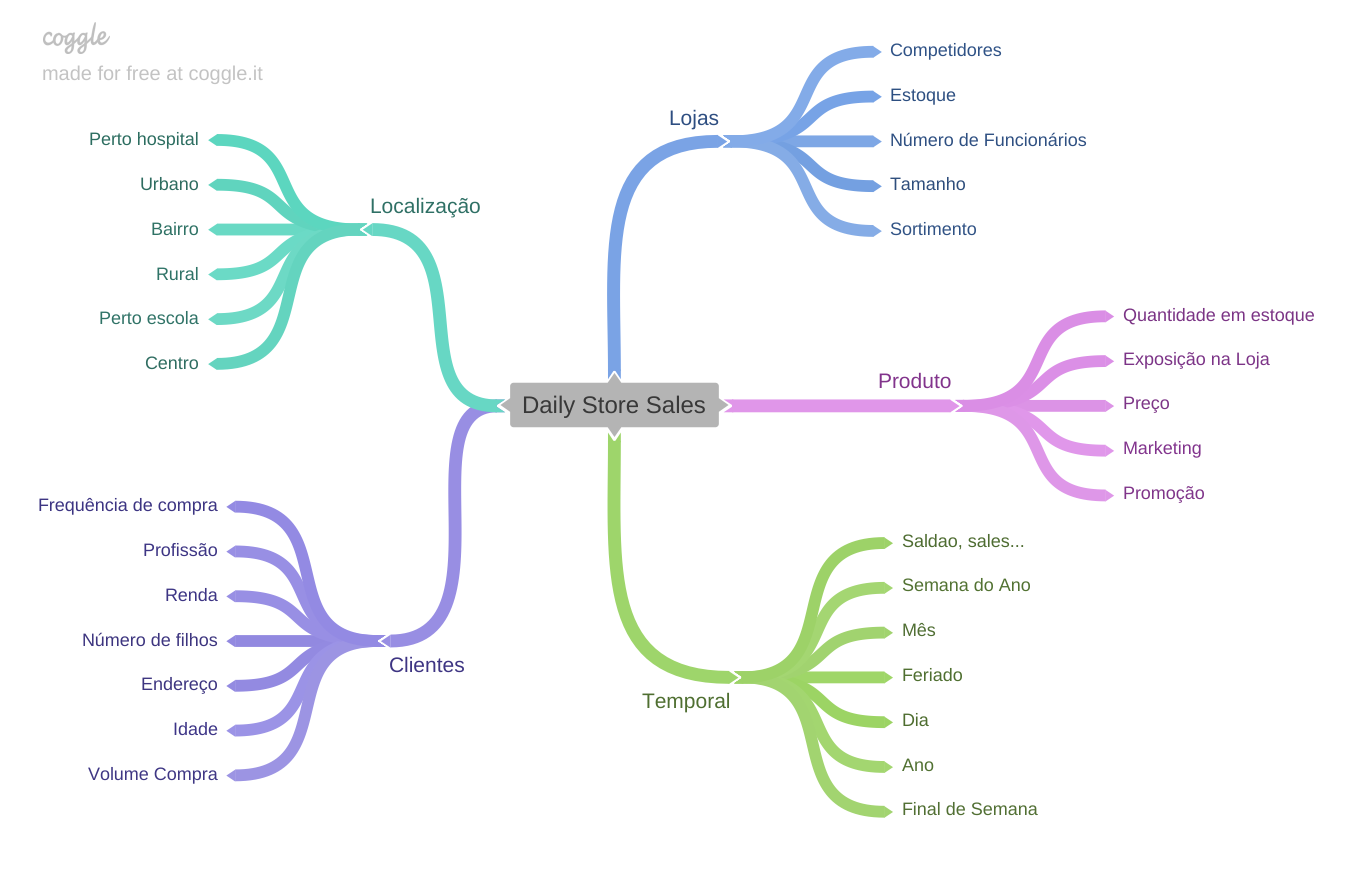

In [29]:
Image(filename='img/mm_hip.png') 

## 2.2 Criação das Hipóteses

**2.2.1.** Hipóteses Lojas

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

**2.2.2.** Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**2.2.3.** Hipóteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.3 Lista final de Hipóteses

**1.**   Lojas com maior sortimentos deveriam vender mais.
  
**2.**   Lojas com competidores mais próximos deveriam vender menos.
  
**3.**   Lojas com competidores à mais tempo deveriam vendem mais.
  
**4.**   Lojas com promoções ativas por mais tempo deveriam vender mais
  
**5.**   Lojas com mais dias de promoção deveriam vender mais.
  
**6.**   Lojas com mais promoções consecutivas deveriam vender mais.
  
**7.**   Lojas abertas durante o feriado de Natal deveriam vender mais.
  
**8.**   Lojas deveriam vender mais ao longo dos anos.
  
**9.**   Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.


## 2.4 Feature Engineering

In [46]:
#year
df2['year']=df2['date'].dt.year

#month
df2['month']=df2['date'].dt.month

#week
df2['day']=df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))

#competition since (unidade: mês)
df2['competition_since'] = df2['competition_open_since_year'].astype(str) + '-'+ df2['competition_open_since_month'].astype(str)+'-1'
df2['competition_since'] = df2['competition_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d') )
df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

##promo2 since - formatando em data
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)+'-1'
df2['promo2_since'] = (df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%W-%w'))) - datetime.timedelta(days=7)
#quanto tempo em semanas participa da promo
df2['promo2_time_week'] = ((df2['date']-df2['promo2_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')

#state holiday

df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 
                                                  'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

<ipython-input-46-b2a313676942>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

In [48]:
df3 = df2.copy()

In [49]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_of_date', 'is_promo2',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo2_since',
       'promo2_time_week'],
      dtype='object')

## 3.1 Filtragem de linhas

In [50]:
#Filtragem das linhas
df3 = df3[(df3['sales']>0) & (df3['open']!=0)]

In [71]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'month_of_date', 'is_promo2',
       'year', 'month', 'day', 'week_of_year', 'year_week',
       'competition_since', 'competition_time_month', 'promo_since',
       'promo_time_week'],
      dtype='object')


## 3.1 Seleção de colunas

In [51]:
# Dropping columns
cols_drop = ['customers','open','month_of_date','promo_interval']
df3 = df3.drop(cols_drop,axis=1)

In [52]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo2', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo2_since', 'promo2_time_week'],
      dtype='object')

- Colunas 'month_of_date' e 'promo_interval' foram excluídas devido a já esterem sido derivadas em outras colunas;
- Coluna 'open' foi excluída porque foram filtrados apenas do dados em que 'open' = 1 (loja aberta), que é de fato o que nos interessa e nos serve para o problema de negócio;
- Coluna 'costumers' foi excluída porque é uma informação que não temos disponível no momento da predição, é um dado consequente.

# 4.0. PASSO 04 -  EXPLORATORY DATA ANALYSIS

In [180]:
df4 = df3.copy()

In [181]:
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo2,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo2_since,promo2_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## Análise Univariada

### Response Variable

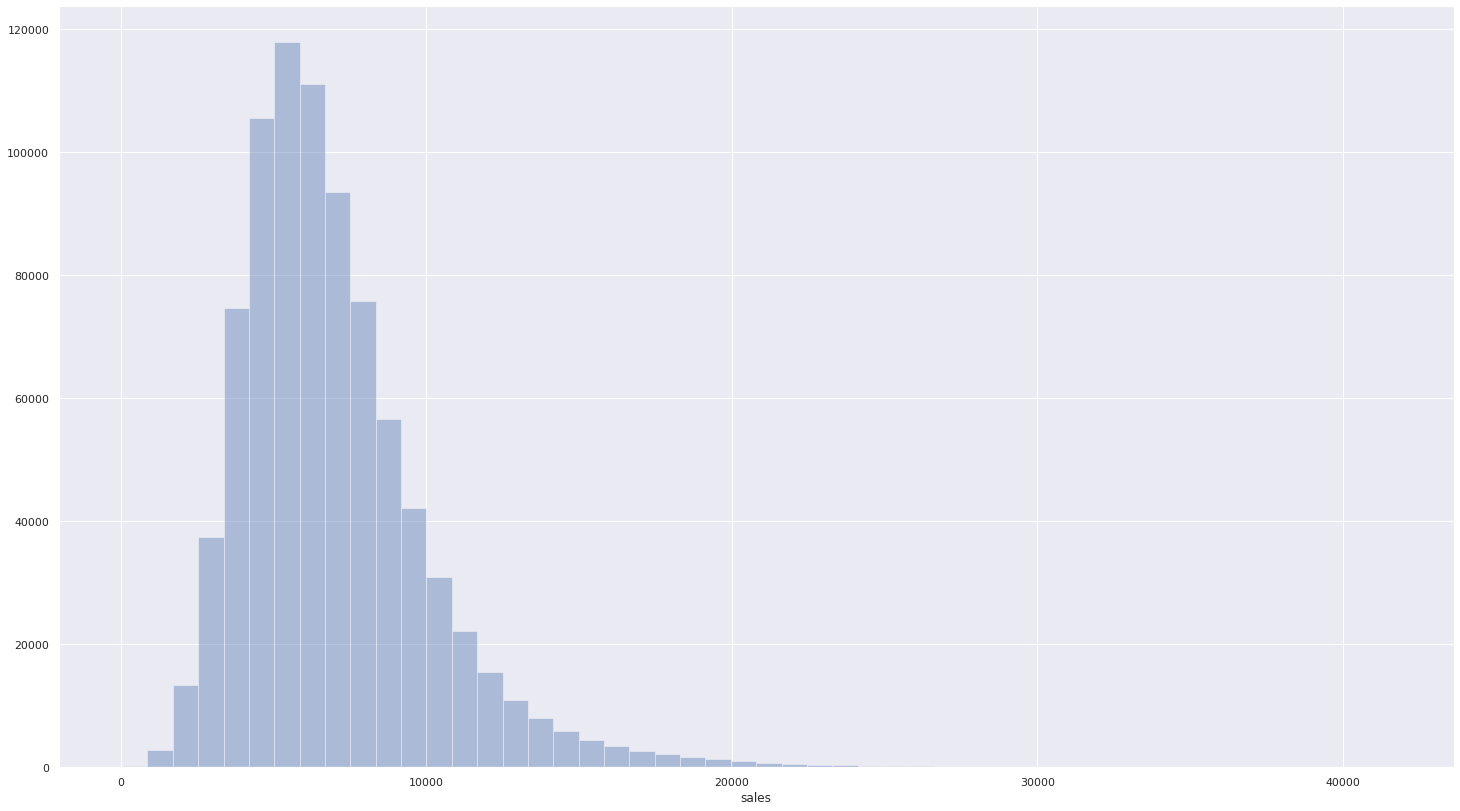

In [78]:
sns.distplot(df4['sales'], kde = False);

### Numerical Attributes

In [182]:
num_attributes = df4.select_dtypes(include=['int64','float64'])
num_attributes = num_attributes.drop(['promo','school_holiday','promo2','is_promo2'],axis=1)

In [183]:
num_attributes.columns

Index(['store', 'day_of_week', 'sales', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year',
       'promo2_since_week', 'promo2_since_year', 'year', 'month', 'day',
       'week_of_year', 'competition_time_month', 'promo2_time_week'],
      dtype='object')

In [184]:
num_attributes.shape

(844338, 14)

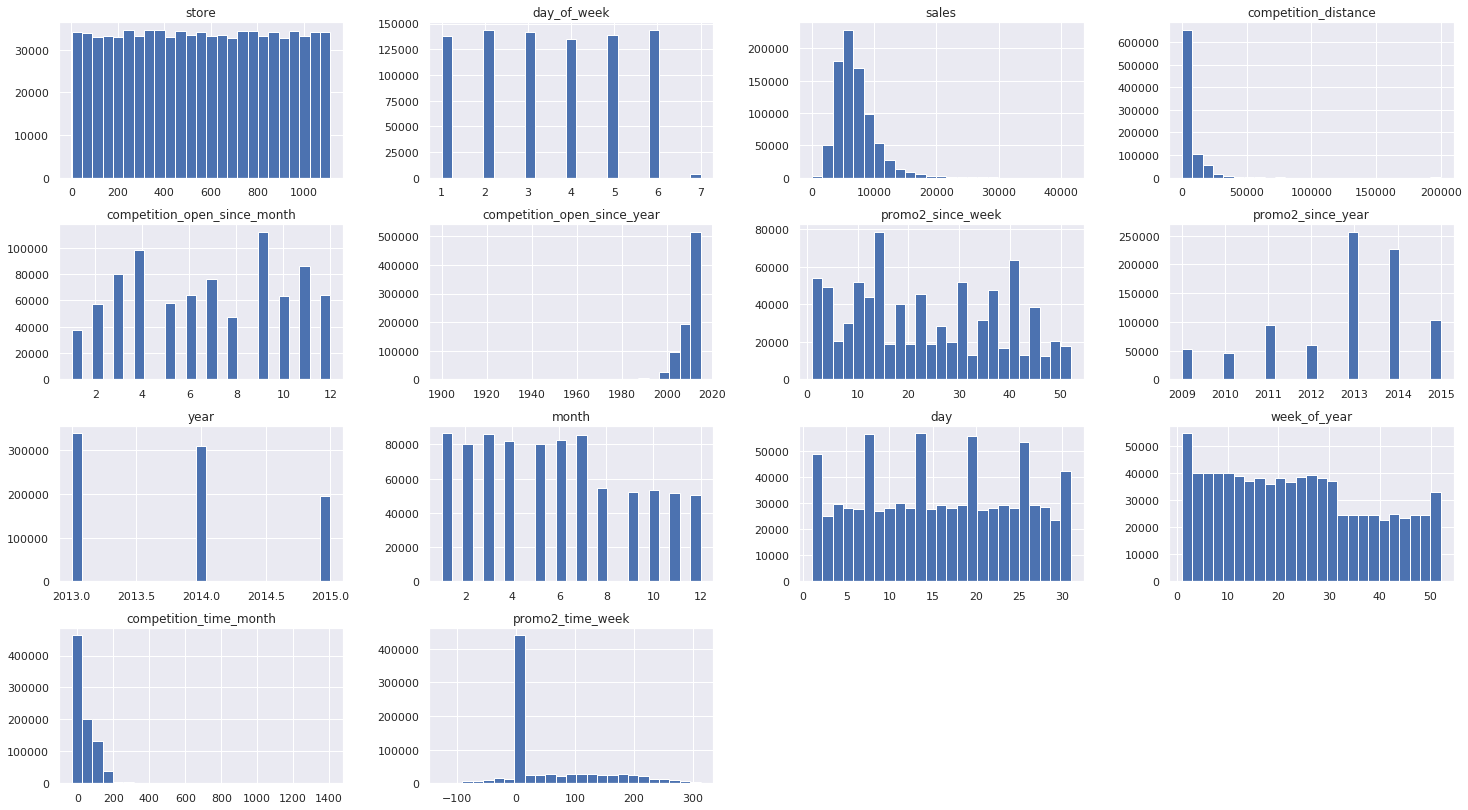

In [63]:
num_attributes.hist(bins=25);

### Categorical Attributes

In [186]:
cat_attributes = df4.drop(num_attributes.columns,axis=1)

In [187]:
cat_attributes.columns

Index(['date', 'promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'promo2', 'is_promo2', 'year_week', 'competition_since',
       'promo2_since'],
      dtype='object')

- Serão plotados gráficos de densidade de probabilidade (kde) e de barras que descreve a contagem das observações de cada variável.

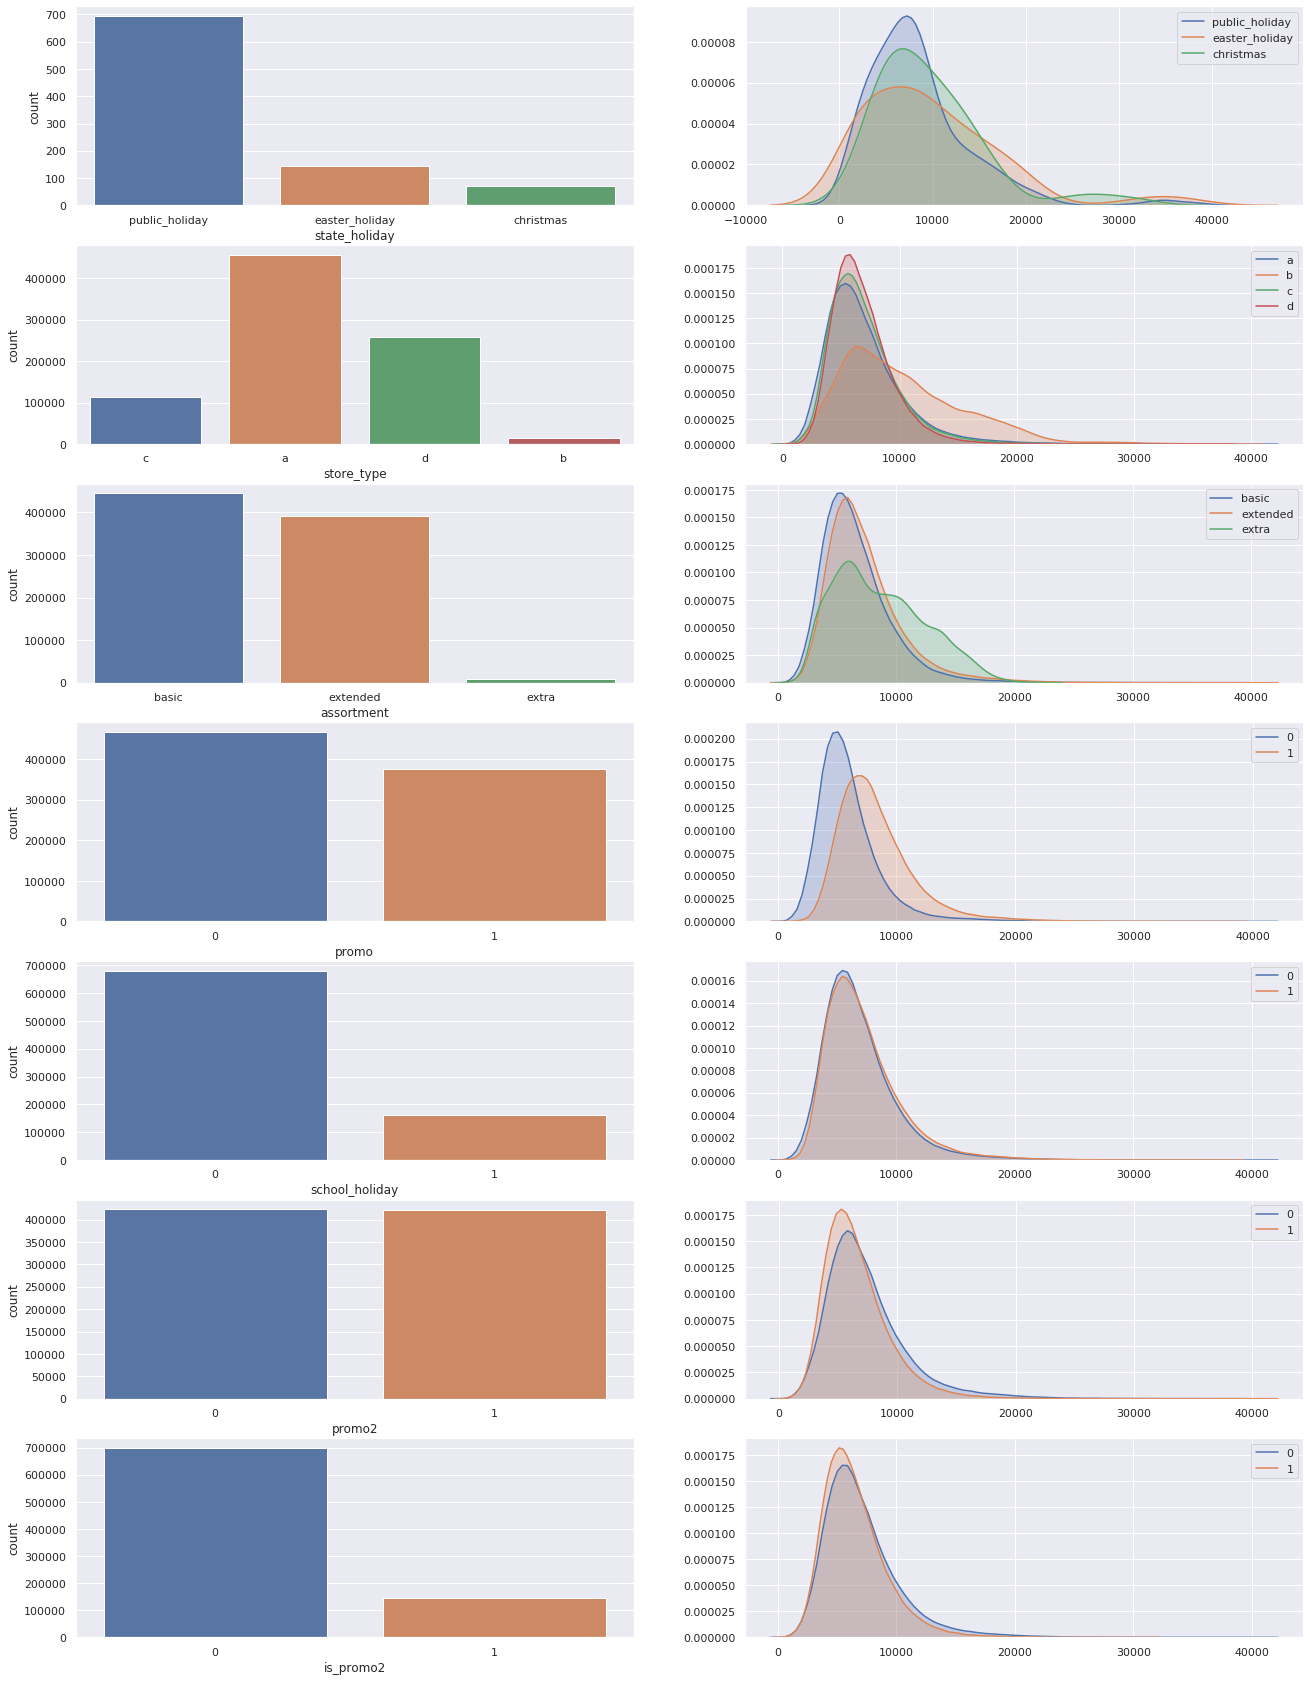

In [97]:

plt.figure(figsize=(22,30))

#STATE HOLIDAY
plt.subplot(7,2,1)
aux1 = df4[df4['state_holiday']!='regular_day']
sns.countplot(x='state_holiday',data=aux1)
plt.subplot(7,2,2)
sns.kdeplot(df4[df4['state_holiday']=='public_holiday']['sales'],label='public_holiday',shade='True')
sns.kdeplot(df4[df4['state_holiday']=='easter_holiday']['sales'],label='easter_holiday',shade='True')
sns.kdeplot(df4[df4['state_holiday']=='christmas']['sales'],label='christmas',shade='True')

#STORE TYPE
plt.subplot(7,2,3)
sns.countplot(x='store_type',data=df4)
plt.subplot(7,2,4)
sns.kdeplot(df4[df4['store_type']=='a']['sales'],label='a',shade='True')
sns.kdeplot(df4[df4['store_type']=='b']['sales'],label='b',shade='True')
sns.kdeplot(df4[df4['store_type']=='c']['sales'],label='c',shade='True')
sns.kdeplot(df4[df4['store_type']=='d']['sales'],label='d',shade='True')

#ASSORTMENT
plt.subplot(7,2,5)
sns.countplot(x='assortment',data=df4)
plt.subplot(7,2,6)
sns.kdeplot(df4[df4['assortment']=='basic']['sales'],label='basic',shade='True')
sns.kdeplot(df4[df4['assortment']=='extended']['sales'],label='extended',shade='True')
sns.kdeplot(df4[df4['assortment']=='extra']['sales'],label='extra',shade='True')


#PROMO
plt.subplot(7,2,7)
sns.countplot(x='promo',data=df4)
plt.subplot(7,2,8)
sns.kdeplot(df4[df4['promo']==0]['sales'],label='0',shade='True')
sns.kdeplot(df4[df4['promo']==1]['sales'],label='1',shade='True')


#SCHOOL HOLIDAY
plt.subplot(7,2,9)
sns.countplot(x='school_holiday',data=df4)
plt.subplot(7,2,10)
sns.kdeplot(df4[df4['school_holiday']==0]['sales'],label='0',shade='True')
sns.kdeplot(df4[df4['school_holiday']==1]['sales'],label='1',shade='True')


#PROMO2
plt.subplot(7,2,11)
sns.countplot(x='promo2',data=df4)
plt.subplot(7,2,12)
sns.kdeplot(df4[df4['promo2']==0]['sales'],label='0',shade='True')
sns.kdeplot(df4[df4['promo2']==1]['sales'],label='1',shade='True')


#IS PROMO2
plt.subplot(7,2,13)
sns.countplot(x='is_promo2',data=df4)
plt.subplot(7,2,14)
sns.kdeplot(df4[df4['is_promo2']==0]['sales'],label='0',shade='True')
sns.kdeplot(df4[df4['is_promo2']==1]['sales'],label='1',shade='True')

- Há um certo desbalanceamento nas característas de algumas features, que deve ser considerado nas análises das hipóteses.
- Observando o gráfico de densidade de probabilidade das features 'promo2','is_promo2','school_holiday', observa-se que não há uma grande variação de comportamento das curvas para cada observação assumida na variável.
- O feriado de Natal mesmo apresentando um menor volume de ocorrência, por motivos óbvios, apresenta grande valores e volume de vendas, relativamente.

## Análise Bivariada

### H1.Lojas com maior sortimento deveriam vender mais.
**Verdadeiro. Lojas classificadas com 'assortment' extra, em média, vendem mais.**
  

In [47]:
df4['assortment'].unique()

array(['basic', 'extended', 'extra'], dtype=object)

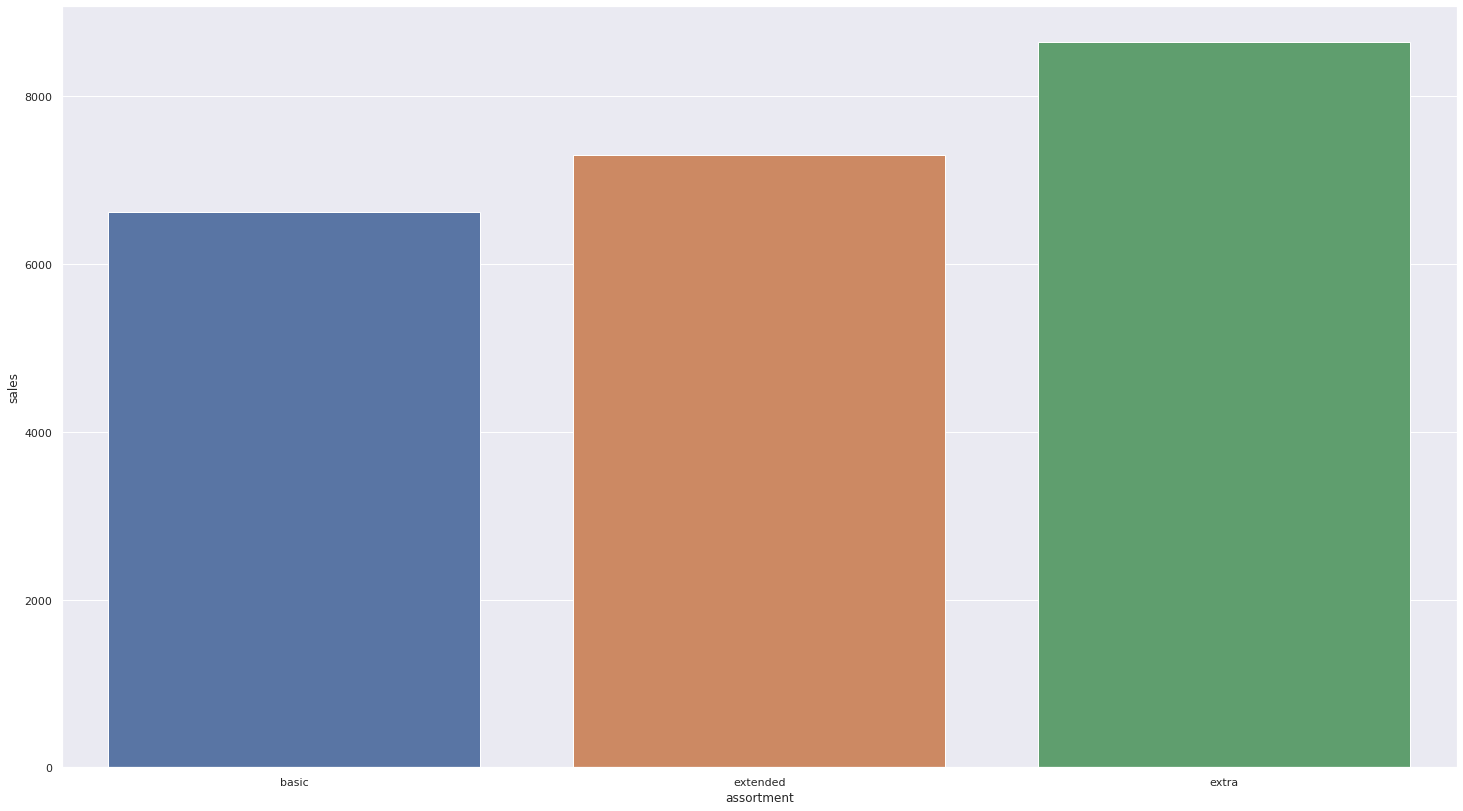

In [48]:
aux1 = df4[['assortment','sales']].groupby('assortment').mean().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1)

In [69]:
aux_2.sample(5)

,assortment,year_week,sales
345,extra,2014-18,9354.047619
260,extended,2015-17,9451.371418
28,basic,2013-28,7469.527559
281,extra,2013-07,6841.507937
185,extended,2013-48,9412.428247


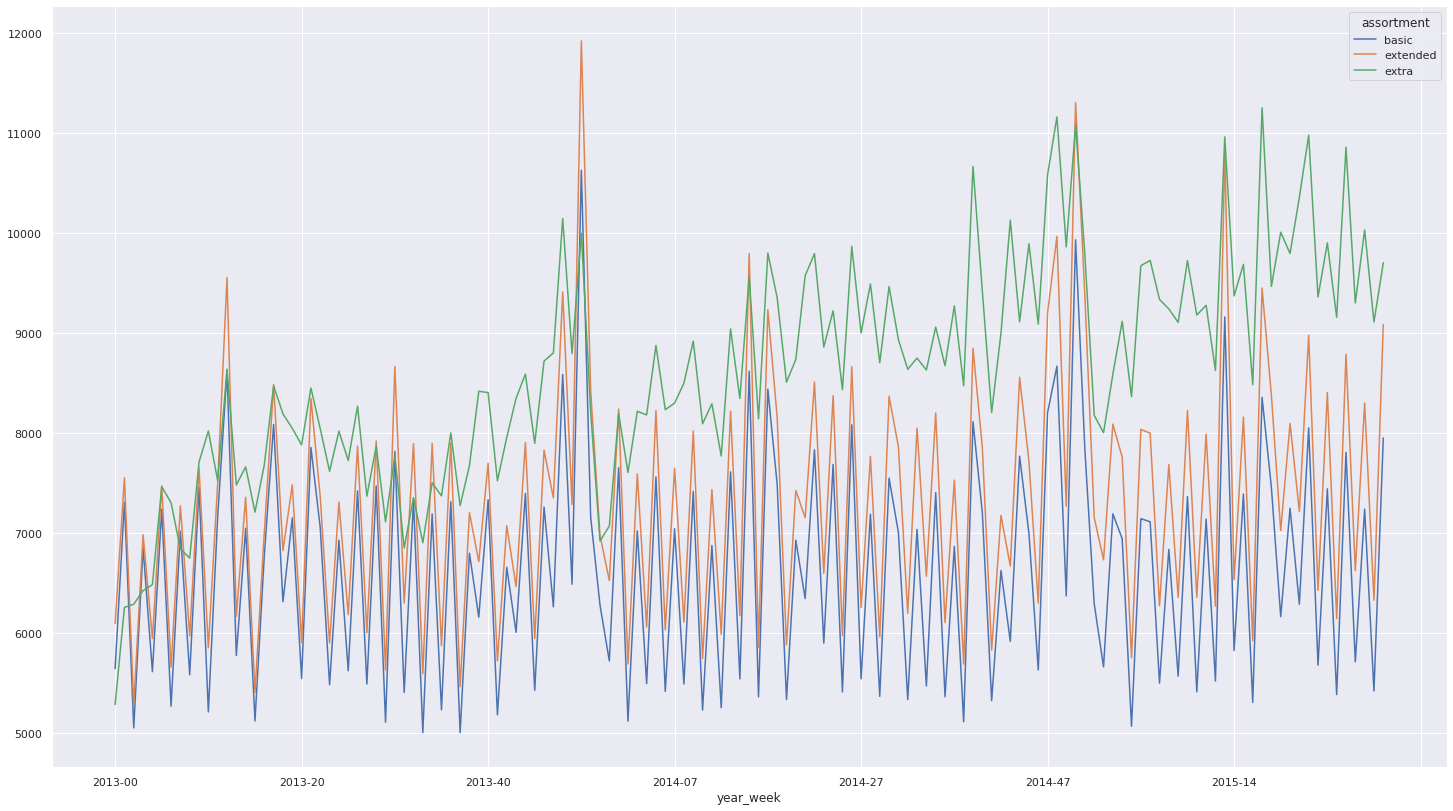

In [68]:
aux_2 = df4[['assortment','year_week','sales']].groupby(['assortment','year_week']).mean().reset_index()
aux_2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.
 **Falsa. Obersava-se que não há uma influência clara da variável distância em relação a média de vendas, notando-se um comportamento similar entre lojas que tem competidoras próximas e lojas que tem competidoras mias distante.**

In [86]:
#Agrupando por 'competition_distance' e calculando a média das vendas por 'competition_distance'
aux_1 = df4[['competition_distance','sales']].groupby('competition_distance').mean().reset_index()

#Criando uma coluna que define a que intervalo pertence de acordo com a 'competition_distance'
bins = list(np.arange(0,20000,1000))
aux_1['inter_competition_distance'] = pd.cut(aux_1['competition_distance'], bins=bins)

#Agrupando por intervalo ('inter_competition_distance') e calculando a média das vendas por intervalo
aux_2 = aux_1[['inter_competition_distance','sales']].groupby('inter_competition_distance').mean().reset_index()

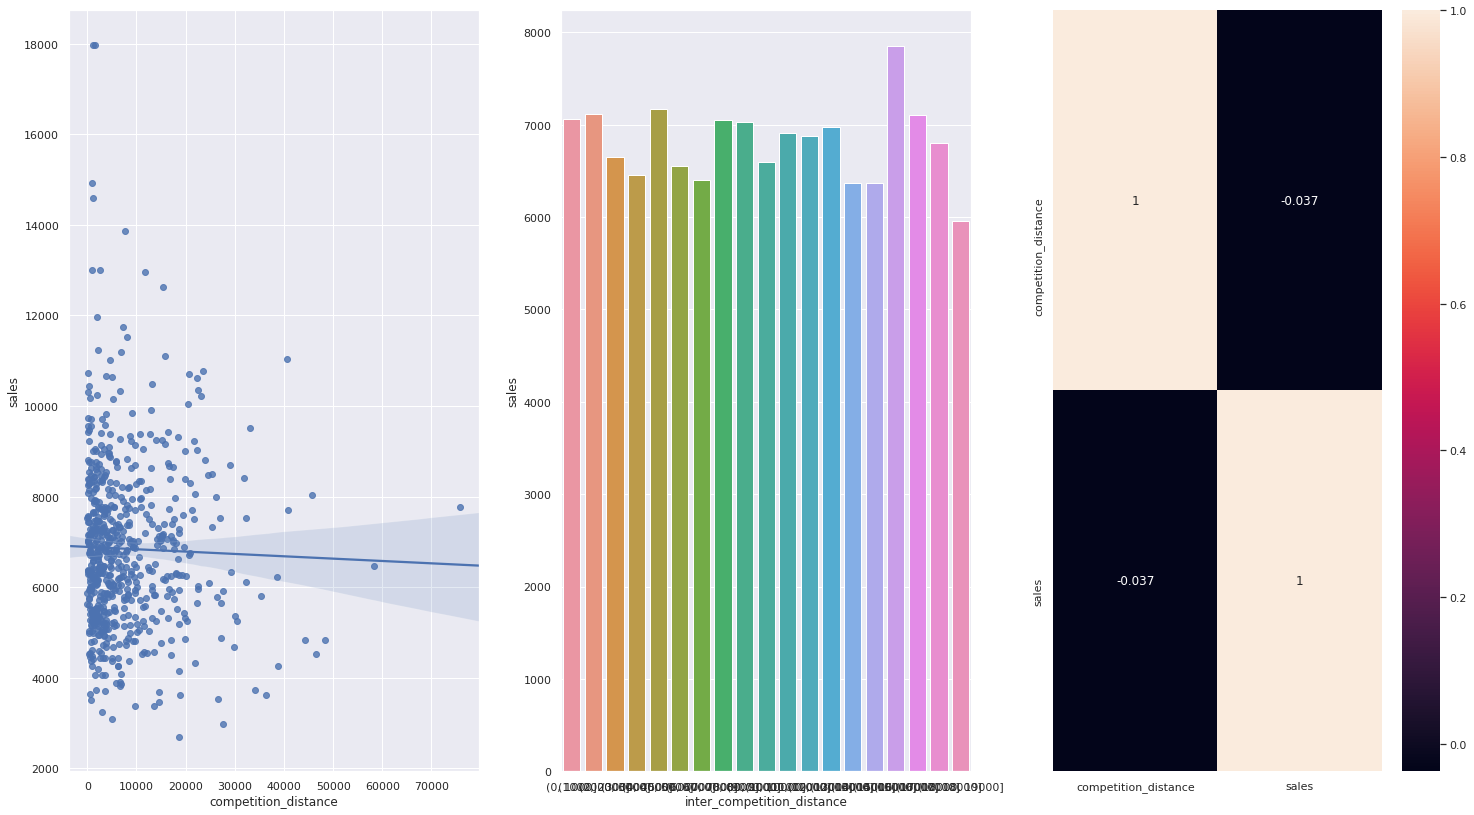

In [92]:
plt.subplot(1,3,1)
sns.regplot(x='competition_distance',y='sales',data=aux_1.loc[aux_1['competition_distance']<200000])

plt.subplot(1,3,2)
sns.barplot(x='inter_competition_distance',y='sales',data=aux_2)

plt.subplot(1,3,3)
sns.heatmap(aux_1.corr( method='pearson' ),annot=True)

### H3. Lojas com competidores à mais tempo deveriam vendem mais.
 **Falsa. Notou-se uma leve tendência em lojas com competidores a mais tempo em apresentar um menor valor médio das vendas.**

In [113]:
#Competition_time_month representa o tempo em meses que a loja tem competidores próximos em relação a data da venda('date')

aux = df4[df4['competition_time_month']>0] #considera apenas as vendas das datas em que a loja já tinha competidor próximo

#Agrupando por loja e observando há quanto tempo já estava competidor (max() -> diferença entre a última data de venda e a data que começou a ter competidor.)
aux_1 = aux[['store','competition_time_month']].groupby('store').max().reset_index()

#Agrupando por loja e calculando a média das vendas - considerando apenas o período em que se tem competidor.
aux_2 = aux[['store','sales']].groupby('store').mean().reset_index()

In [114]:
#Unindo os dataframes agrupados, agrupando por loja 
aux_3 = pd.merge(aux_1,aux_2, how='inner',on='store')

In [115]:
aux_3.head()

,store,competition_time_month,sales
0,1,84,4759.096031
1,2,94,4953.900510
2,3,105,6942.568678
3,4,71,9638.401786
4,5,4,4689.828947


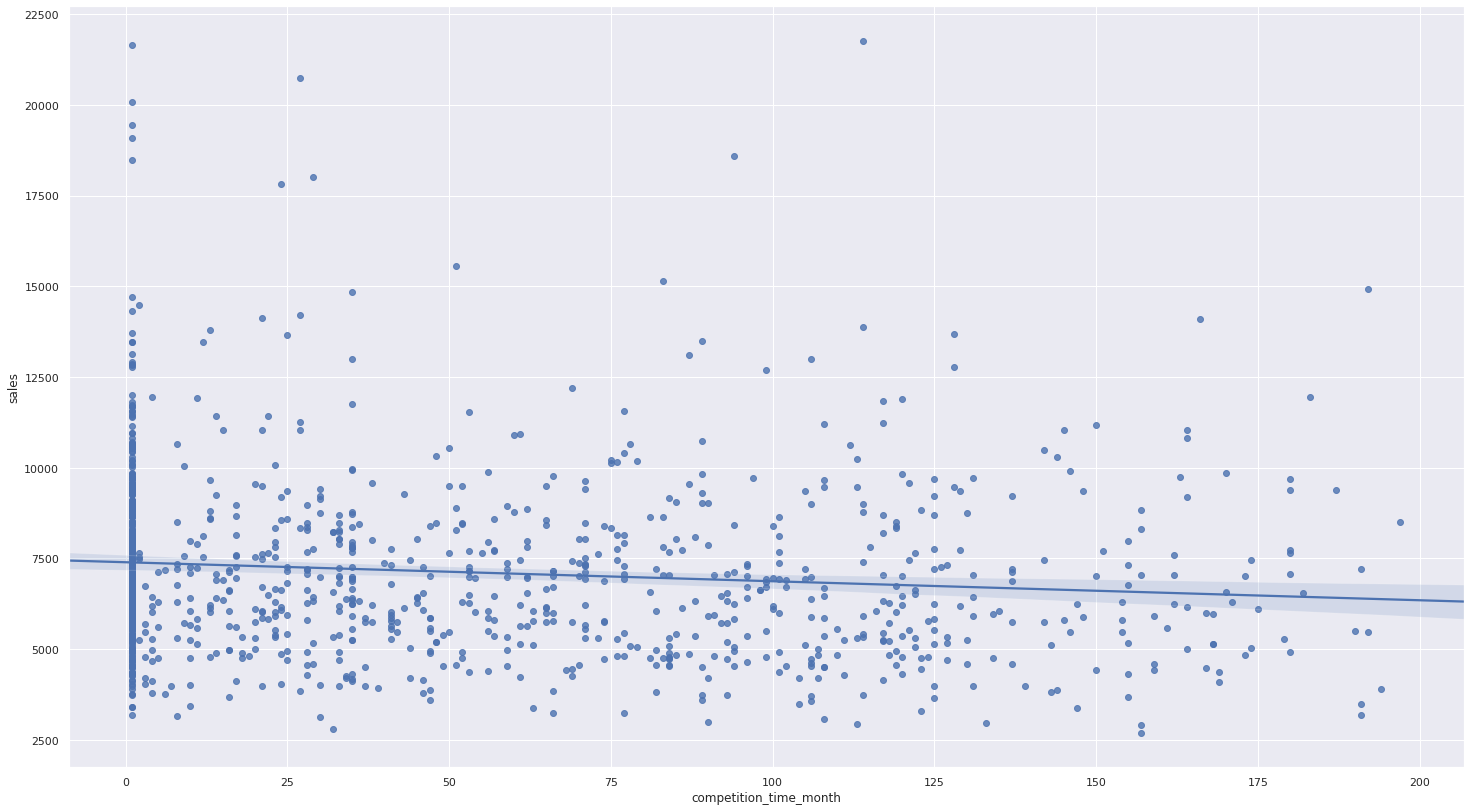

In [118]:
#Plot 
sns.regplot(x='competition_time_month',y='sales',data=aux_3.loc[aux_3['competition_time_month']<200]);

### H4. Lojas com promoção estendida ativa há mais tempo deveriam vender mais.
**Falsa. Notou-se uma leve tendência em lojas com promoção estendida ativa a mais tempo em apresentar um menor valor médio das vendas.**

In [119]:
#Filtrando apenas as vendas que ocorreram após a promo2 ser ativada
aux = df4[df4['promo2_time_week']>0]

#Agrupando por loja e observando há quanto tempo a promo2 está ativada em relação ao último dia de venda presente na base de dados.
aux_1 = aux[['store','promo2_time_week']].groupby('store').max().reset_index()

#Agrupando por loja e calculando a média de vendas a partir do período em que a promo2 foi ativada
aux_2 = aux[['store','sales']].groupby('store').mean().reset_index()

In [120]:
#Unindo os dataframes
aux_3 = pd.merge(aux_1,aux_2, how='inner',on='store')

In [121]:
aux_3.head()

,store,promo2_time_week,sales
0,1,52,5017.800000
1,2,279,4953.900510
2,3,226,6942.568678
3,4,52,13556.000000
4,5,52,4044.400000


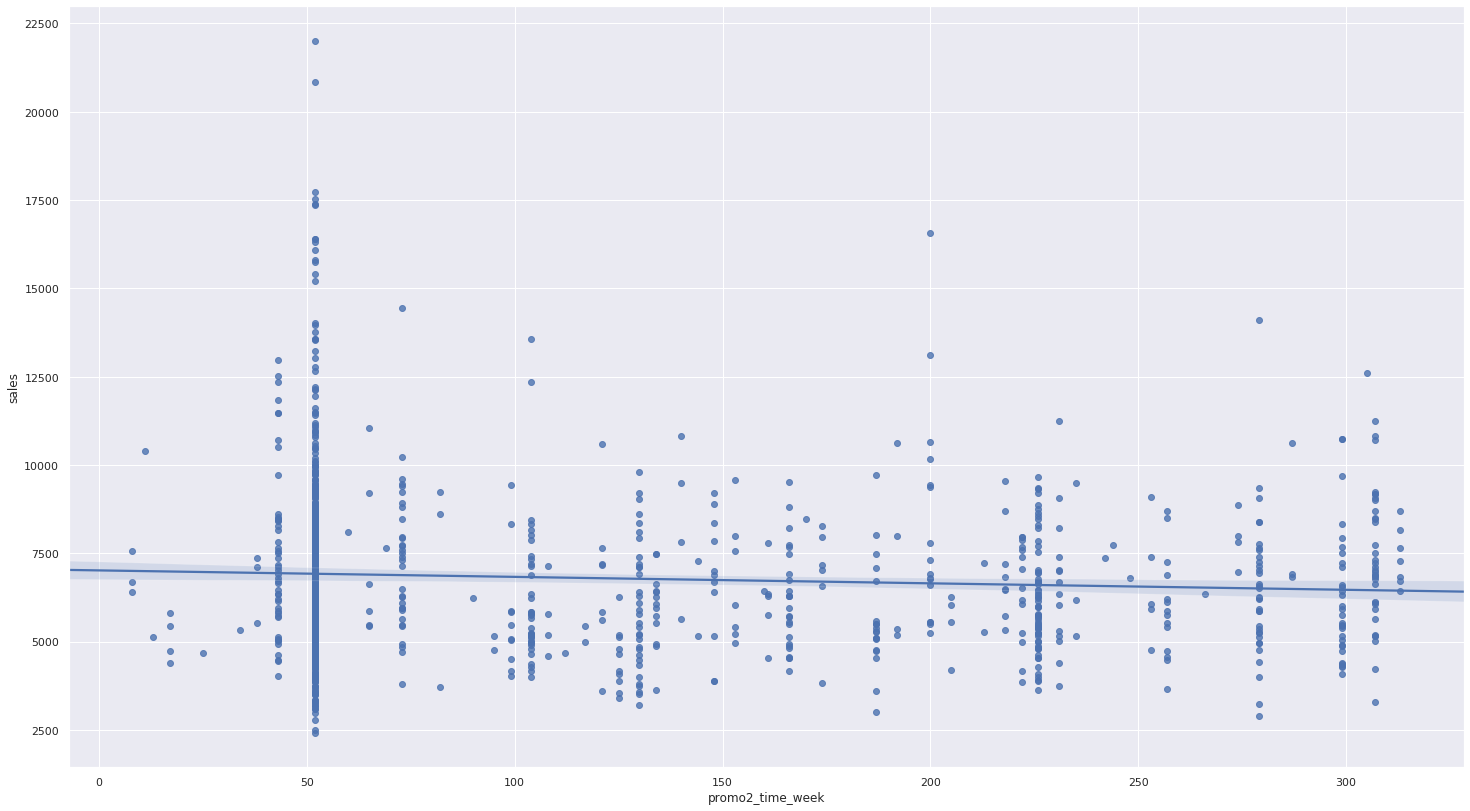

In [122]:
#Plot
sns.regplot(x='promo2_time_week',y='sales',data=aux_3)

### H5. Lojas quando estão em promoção estendida vendem mais.
**Falsa. Lojas quando estão nos meses da promoção estendida, não vendem mais.**

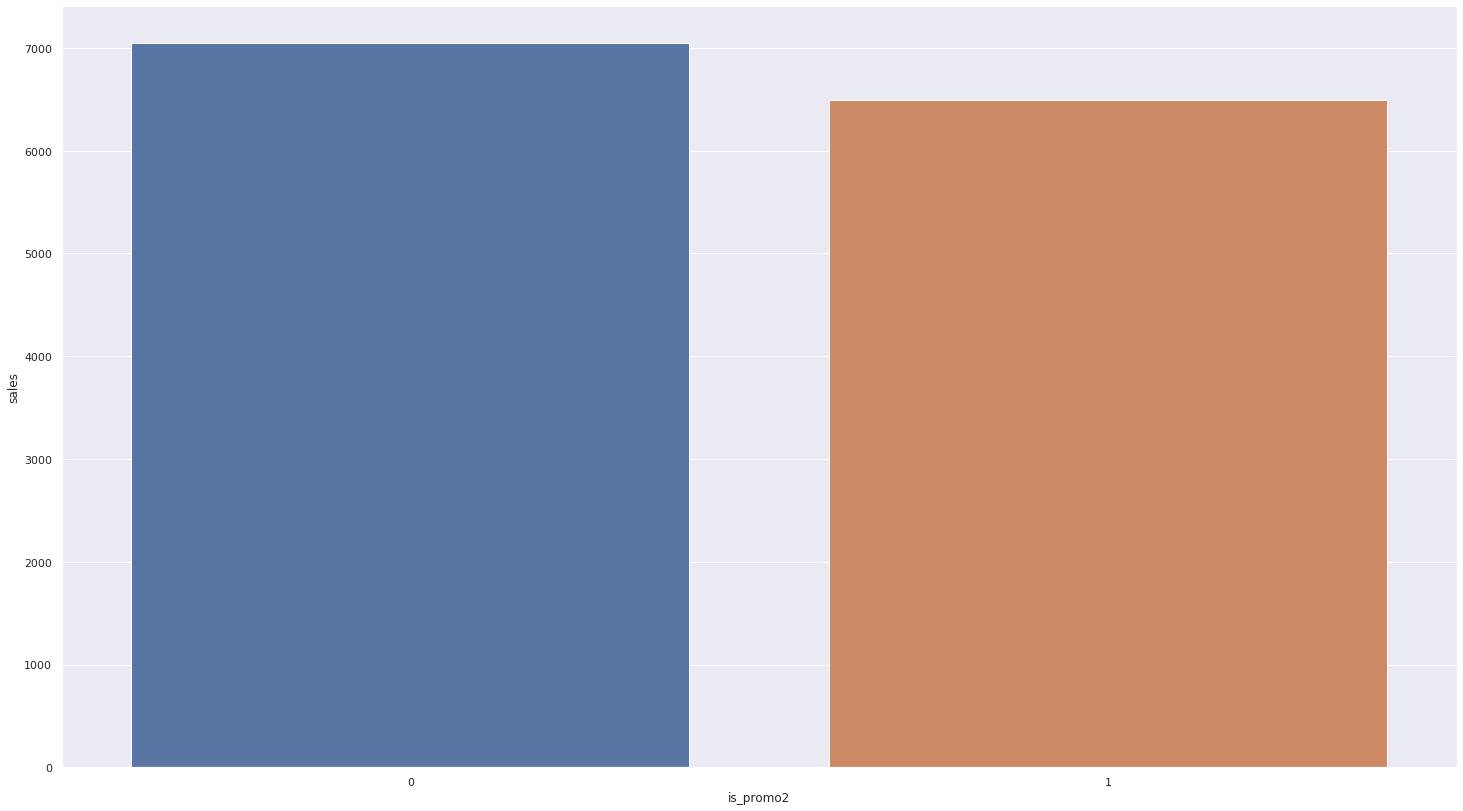

In [136]:
sns.barplot(x='is_promo2',y='sales',data=aux)

### H6. Lojas que participam de promoções consecutivas deveriam vender mais.
**Falsa. Lojas que não participam do período de promoção consecutiva, em média, vende menos.**

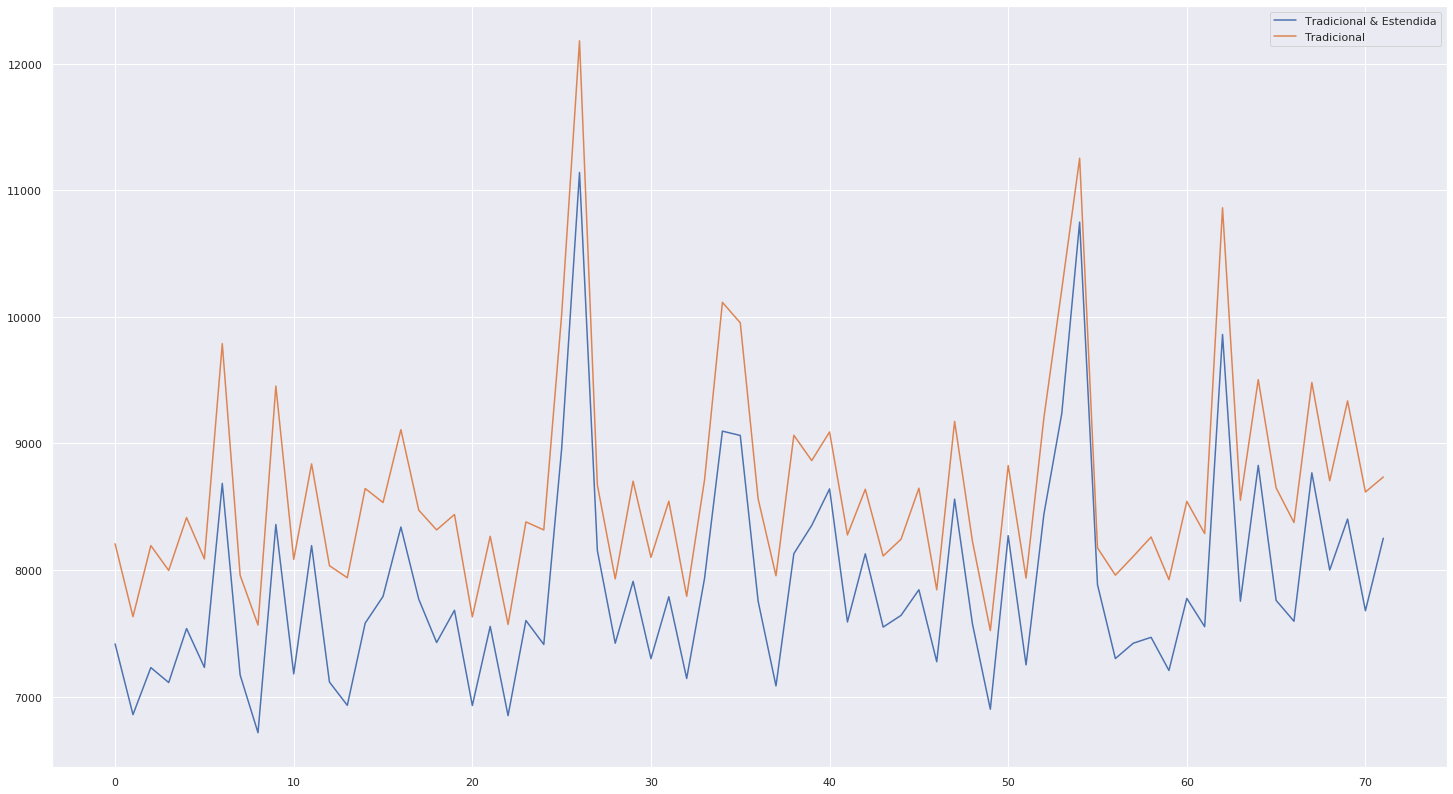

In [281]:
#Lojas com mais promoções consecutivas são aquelas que participam da promo1 e da promo2 (lembrando que promo2=1 significa apenas que a loja participa dessa promoção, mas não necessariamente que no dia da venda ela está participando)

aux_1 = df4[(df4['promo']==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').mean().reset_index()
ax = aux_1.plot()

#Lojas com menos promoções consecutivas são aquelas que participam apenas da promo1
aux_2 = df4[(df4['promo']==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').mean().reset_index()
aux_2.plot(ax=ax)

ax.legend( labels=['Tradicional & Estendida', 'Tradicional']);

### H7. O feriado de Natal  é o que as lojas deveriam vender mais.
 **Falsa. O feriado de Natal vende menos que os outros dias de feriado.**

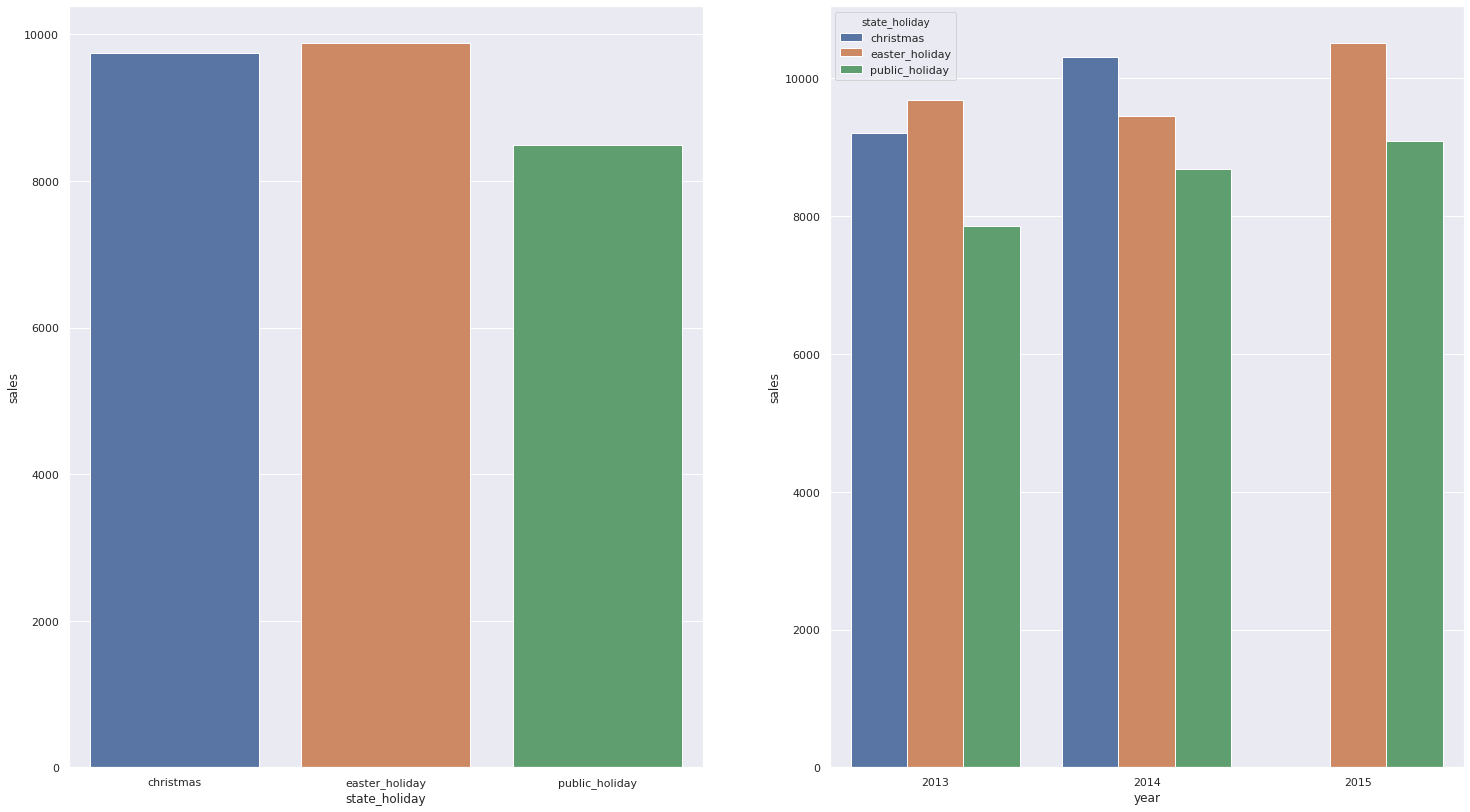

In [169]:
aux=df4[df4['state_holiday']!='regular_day']

aux_1 = aux[['state_holiday','sales']].groupby('state_holiday').mean().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='state_holiday',y='sales',data=aux_1)

#Analisando ao longo dos anos
plt.subplot(1,2,2)
aux_2 = aux[['state_holiday','sales','year']].groupby(['year','state_holiday']).mean().reset_index()
sns.barplot(x='year',y='sales',hue='state_holiday',data=aux_2)

### H8. As lojas deveriam vender mais ao longo dos anos.
**Falsa. As vendas estão caindo ao longo dos anos.**
  

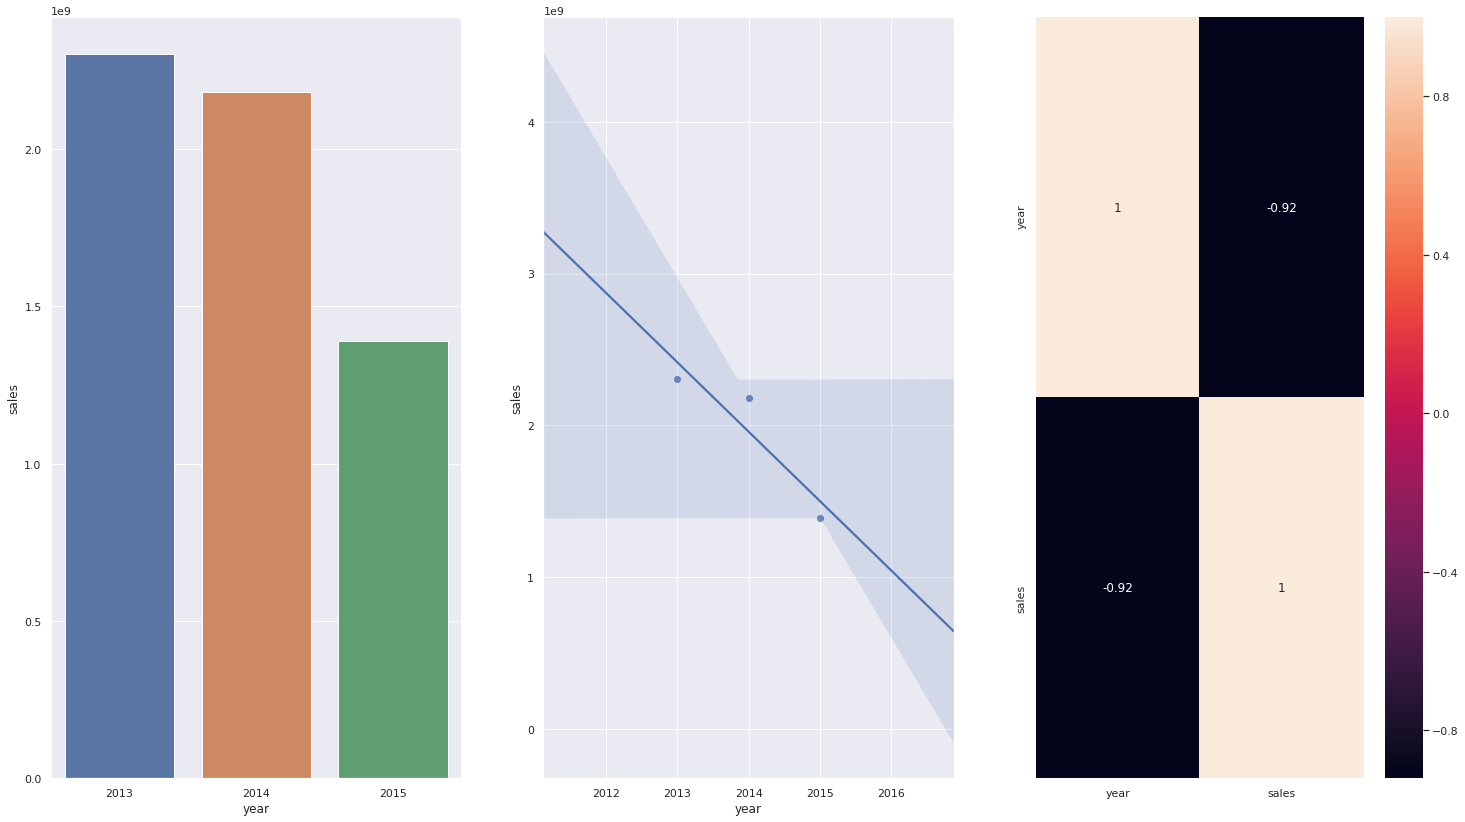

In [170]:
aux = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year',y='sales',data=aux)

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H9. Lojas deveriam vender mais no segundo semestre do ano.
 **Falsa. As lojas vendem mais no primeiro semestre do ano.**

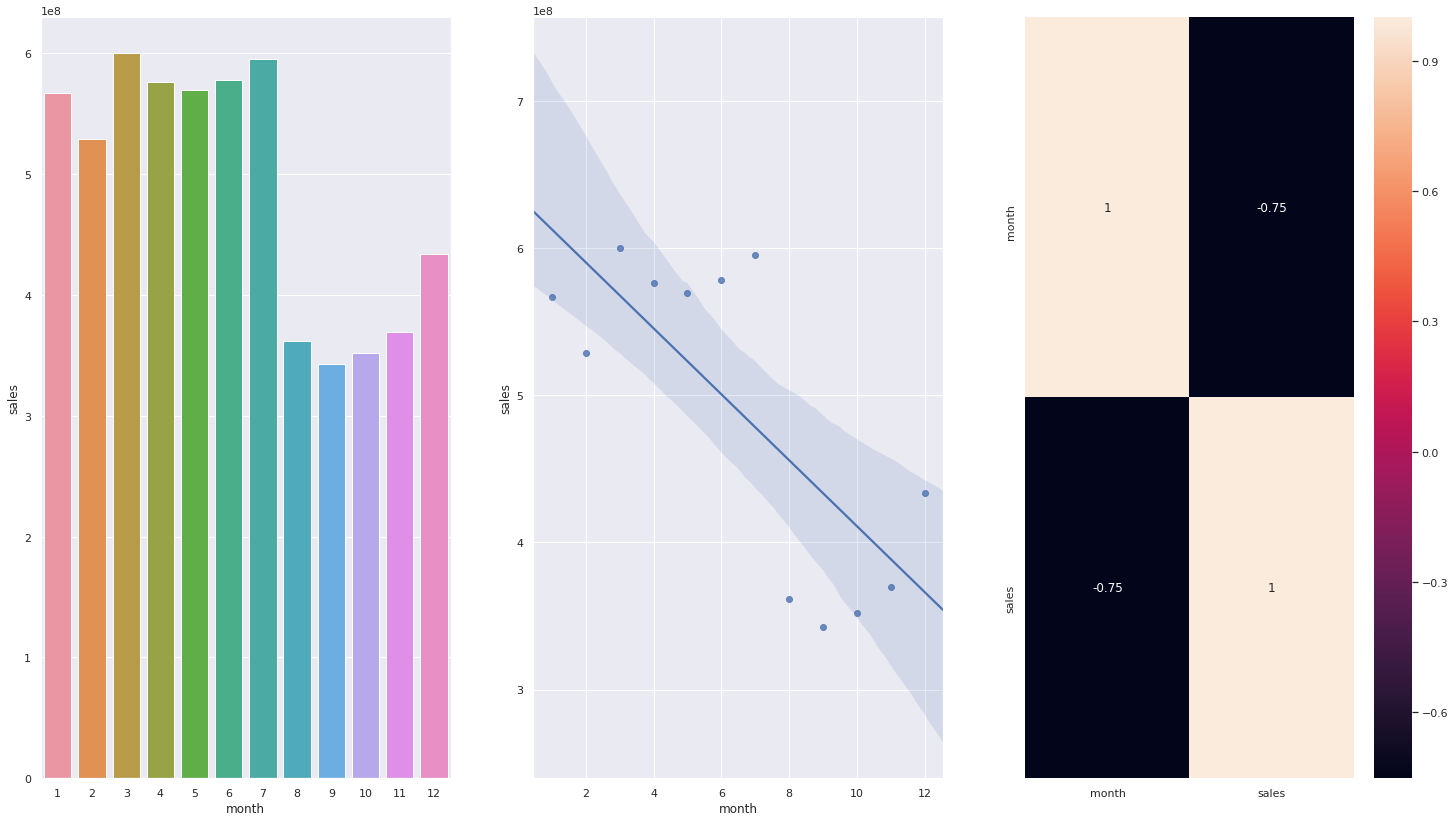

In [171]:
aux = df4[['month','sales']].groupby('month').sum().reset_index()

spec = GridSpec(1,3)

subplot(spec[0,0])
sns.barplot(x='month',y='sales',data=aux)

subplot(spec[0,1])
sns.regplot(x='month',y='sales',data=aux)

subplot(spec[0,2])
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
 **Falsa. Notou-se que as lojas vendem mais antes do dia 10 de cada mês**

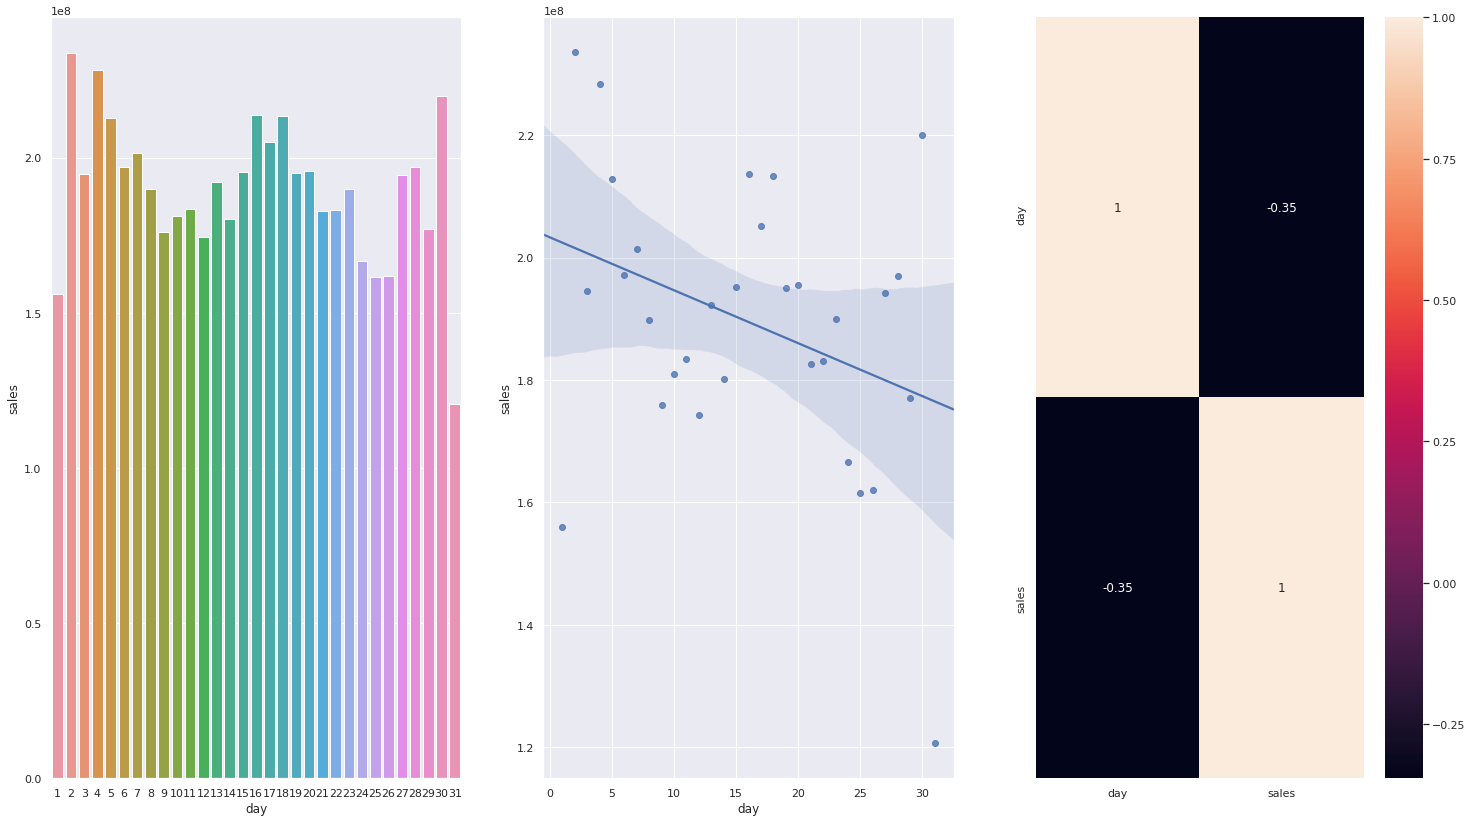

In [172]:
aux = df4[['day','sales']].groupby('day').sum().reset_index()

spec = GridSpec(1,3)

subplot(spec[0,0])
sns.barplot(x='day',y='sales',data=aux)

subplot(spec[0,1])
sns.regplot(x='day',y='sales',data=aux)

subplot(spec[0,2])
sns.heatmap(aux.corr(method='pearson'),annot=True)

### H11. Lojas deveriam vender menos aos finais de semana.
**Verdadeiro. Lojas vendem menos durantes os finais de semana.**

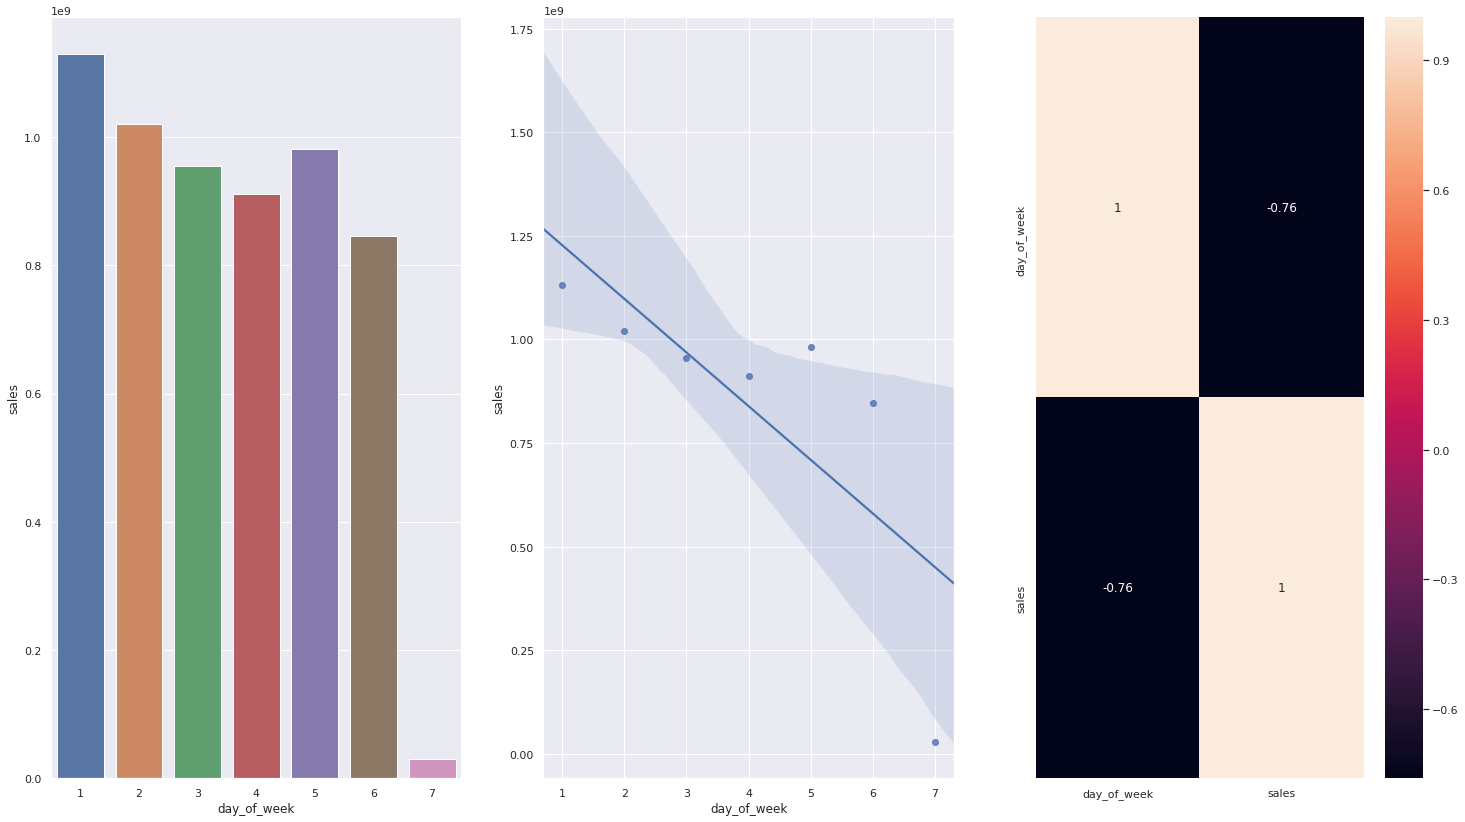

In [173]:
aux = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week',y='sales',data=aux)

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux)

plt.subplot(1,3,3)
sns.heatmap(aux.corr(method='pearson'),annot=True)


### H12. Lojas deveriam vender menos durante os feriados escolares.

**Verdadeiro. Lojas vendem menos durante os feriados escolares, exceto durante o mês de agosto, que é um mês de férias e certamente por isso as vendas são maiores.**

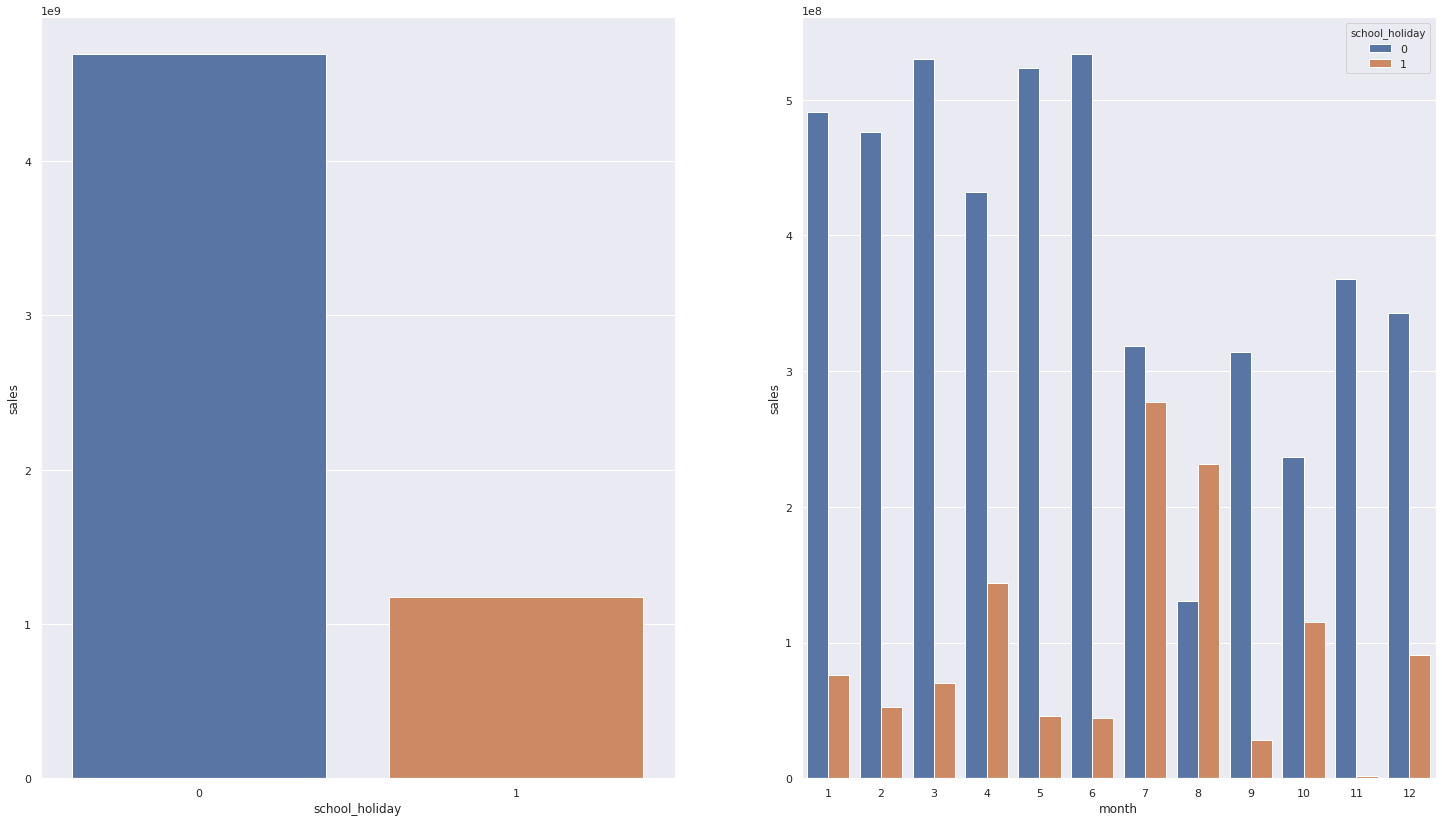

In [174]:
aux = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='school_holiday',y='sales',data=aux)

#Por mês

plt.subplot(1,2,2)
aux_1 = df4[['school_holiday','month','sales']].groupby(['school_holiday','month']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux_1)

### Resumo - Hipóteses

In [282]:
tab = [['Hipótese', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Baixa'],
       ['H2', 'Falsa', 'Alta'],
       ['H3', 'Falsa', 'Média'],
       ['H4', 'Falsa', 'Média'],
       ['H5', 'Falsa', 'Alta'],
       ['H6', 'Falsa', 'Alta'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Baixa'],
       ['H10', 'Falsa', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']
]
print (tabulate(tab, headers='firstrow', tablefmt="fancy_grid"))


╒════════════╤═════════════╤══════════════╕
│ Hipótese   │ Conclusão   │ Relevância   │
╞════════════╪═════════════╪══════════════╡
│ H1         │ Verdadeira  │ Baixa        │
├────────────┼─────────────┼──────────────┤
│ H2         │ Falsa       │ Alta         │
├────────────┼─────────────┼──────────────┤
│ H3         │ Falsa       │ Média        │
├────────────┼─────────────┼──────────────┤
│ H4         │ Falsa       │ Média        │
├────────────┼─────────────┼──────────────┤
│ H5         │ Falsa       │ Alta         │
├────────────┼─────────────┼──────────────┤
│ H6         │ Falsa       │ Alta         │
├────────────┼─────────────┼──────────────┤
│ H7         │ Falsa       │ Baixa        │
├────────────┼─────────────┼──────────────┤
│ H8         │ Falsa       │ Alta         │
├────────────┼─────────────┼──────────────┤
│ H9         │ Falsa       │ Baixa        │
├────────────┼─────────────┼──────────────┤
│ H10        │ Falsa       │ Alta         │
├────────────┼─────────────┼────

## Análise Multivariada

### Numerical Attributes

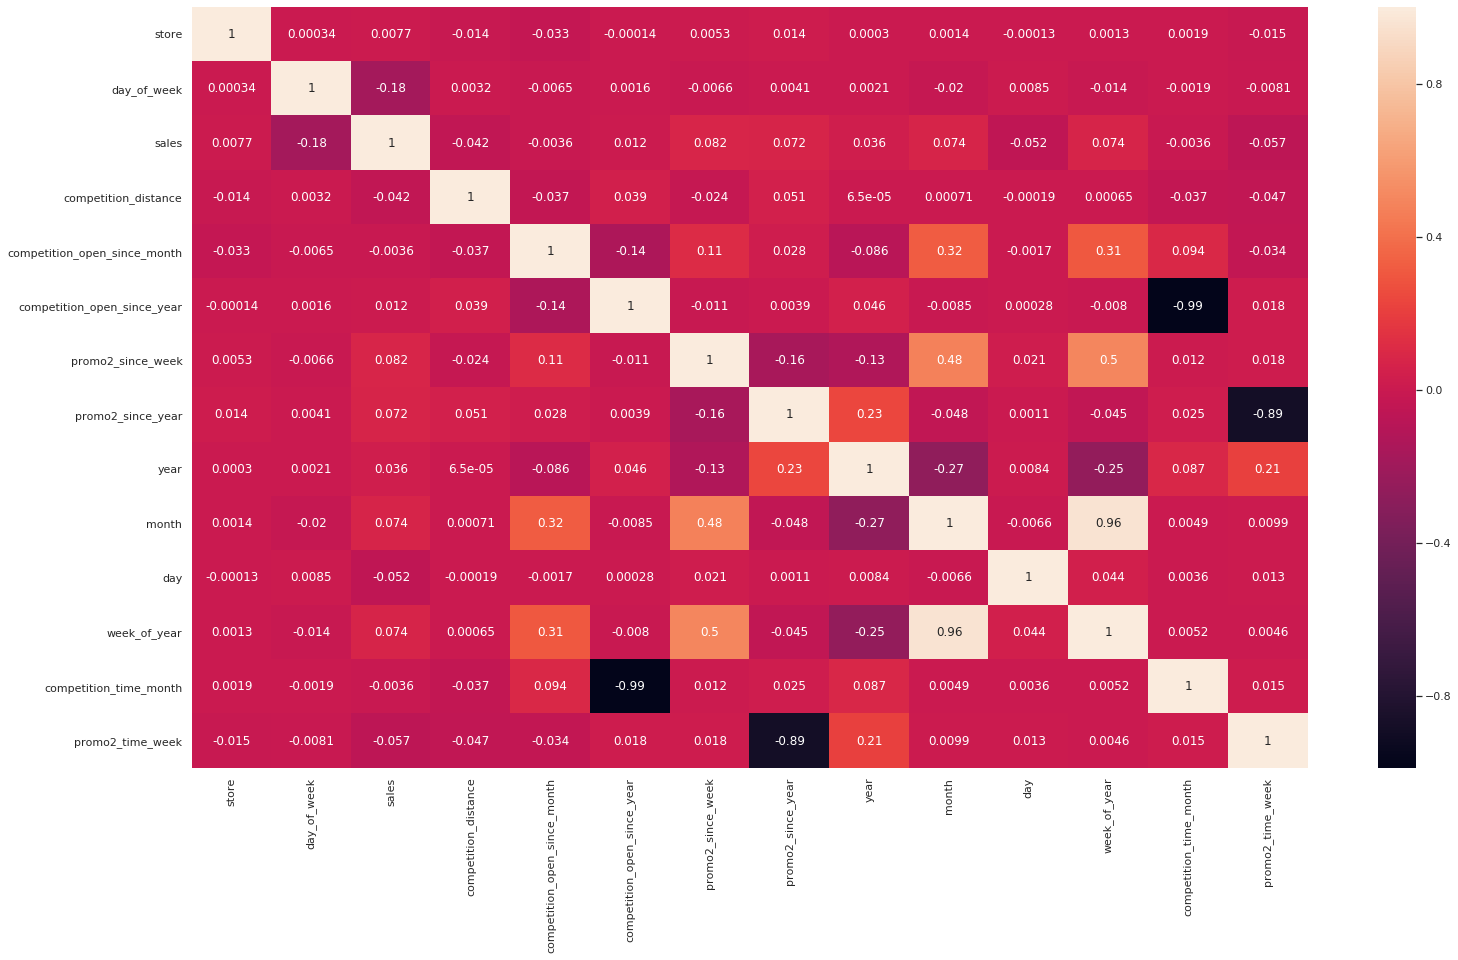

In [189]:
sns.heatmap(num_attributes.corr(method='pearson'),annot=True)

- Maiores valores de correlação são de features que foram deviradas;
- No geral, há uma baixa correlação entre as features.

### Categorical Attributes

In [198]:
cat_attributes.columns

Index(['date', 'promo', 'state_holiday', 'school_holiday', 'store_type',
       'assortment', 'promo2', 'is_promo2', 'year_week', 'competition_since',
       'promo2_since'],
      dtype='object')

- Usando a função Cramers'V que mede a associação entre duas variáveis categóricas, este valor pode estar em (0,+1].

In [199]:
a1 = cramer(cat_attributes['state_holiday'],cat_attributes['state_holiday'])
a2 = cramer(cat_attributes['state_holiday'],cat_attributes['assortment'])
a3 = cramer(cat_attributes['state_holiday'],cat_attributes['store_type'])
a4 = cramer(cat_attributes['state_holiday'],cat_attributes['promo'])
a5 = cramer(cat_attributes['state_holiday'],cat_attributes['promo2'])
a6 = cramer(cat_attributes['state_holiday'],cat_attributes['is_promo2'])
a7 = cramer(cat_attributes['state_holiday'],cat_attributes['school_holiday'])


a8 = cramer(cat_attributes['store_type'],cat_attributes['store_type'])
a9 = cramer(cat_attributes['store_type'],cat_attributes['assortment'])
a10 = cramer(cat_attributes['store_type'],cat_attributes['state_holiday'])
a11 = cramer(cat_attributes['store_type'],cat_attributes['promo'])
a12 = cramer(cat_attributes['store_type'],cat_attributes['promo2'])
a13 = cramer(cat_attributes['store_type'],cat_attributes['is_promo2'])
a14 = cramer(cat_attributes['store_type'],cat_attributes['school_holiday'])

a15 = cramer(cat_attributes['assortment'],cat_attributes['assortment'])
a16 = cramer(cat_attributes['assortment'],cat_attributes['store_type'])
a17 = cramer(cat_attributes['assortment'],cat_attributes['state_holiday'])
a18 = cramer(cat_attributes['assortment'],cat_attributes['promo'])
a19 = cramer(cat_attributes['assortment'],cat_attributes['promo2'])
a20 = cramer(cat_attributes['assortment'],cat_attributes['is_promo2'])
a21 = cramer(cat_attributes['assortment'],cat_attributes['school_holiday'])

a22 = cramer(cat_attributes['promo'],cat_attributes['promo'])
a23 = cramer(cat_attributes['promo'],cat_attributes['assortment'])
a24 = cramer(cat_attributes['promo'],cat_attributes['store_type'])
a25 = cramer(cat_attributes['promo'],cat_attributes['state_holiday'])
a26 = cramer(cat_attributes['promo'],cat_attributes['promo2'])
a27 = cramer(cat_attributes['promo'],cat_attributes['is_promo2'])
a28 = cramer(cat_attributes['promo'],cat_attributes['school_holiday'])

a29 = cramer(cat_attributes['promo2'],cat_attributes['promo2'])
a30 = cramer(cat_attributes['promo2'],cat_attributes['assortment'])
a31 = cramer(cat_attributes['promo2'],cat_attributes['store_type'])
a32 = cramer(cat_attributes['promo2'],cat_attributes['state_holiday'])
a33 = cramer(cat_attributes['promo2'],cat_attributes['promo'])
a34 = cramer(cat_attributes['promo2'],cat_attributes['is_promo2'])
a35 = cramer(cat_attributes['promo2'],cat_attributes['school_holiday'])

a36 = cramer(cat_attributes['is_promo2'],cat_attributes['is_promo2'])
a37 = cramer(cat_attributes['is_promo2'],cat_attributes['assortment'])
a38 = cramer(cat_attributes['is_promo2'],cat_attributes['store_type'])
a39 = cramer(cat_attributes['is_promo2'],cat_attributes['state_holiday'])
a40 = cramer(cat_attributes['is_promo2'],cat_attributes['promo'])
a41 = cramer(cat_attributes['is_promo2'],cat_attributes['promo2'])
a42 = cramer(cat_attributes['is_promo2'],cat_attributes['school_holiday'])

a43 = cramer(cat_attributes['school_holiday'],cat_attributes['school_holiday'])
a44 = cramer(cat_attributes['school_holiday'],cat_attributes['assortment'])
a45 = cramer(cat_attributes['school_holiday'],cat_attributes['store_type'])
a46 = cramer(cat_attributes['school_holiday'],cat_attributes['is_promo2'])
a47 = cramer(cat_attributes['school_holiday'],cat_attributes['promo'])
a48 = cramer(cat_attributes['school_holiday'],cat_attributes['promo2'])
a49 = cramer(cat_attributes['school_holiday'],cat_attributes['state_holiday'])


In [200]:
cramer_tab = pd.DataFrame({'state_holiday':[a1, a3, a2, a4, a5, a6,a7],
              'store_type':[a10,a8,a9,a11,a12,a13,a14],
              'assortment':[a17,a16,a15,a18,a19,a20,a21],
              'promo':[a25,a24,a23,a22,a26,a27,a28],
              'promo2':[a32,a31,a30,a33,a29,a34,a35],
              'is_promo2':[a39,a38,a37,a40,a41,a36,a42],
              'school_holiday':[a49,a45,a44,a47,a48,a46,a43]
             })

In [201]:
cramer_tab = cramer_tab.set_index(cramer_tab.columns)

In [202]:
cramer_tab

,state_holiday,store_type,assortment,promo,promo2,is_promo2,school_holiday
state_holiday,1.000000,0.071040,0.067519,0.010561,0.010331,0.007639,0.031637
store_type,0.071040,1.000000,0.538454,0.017787,0.108171,0.048621,0.004601
assortment,0.067519,0.538454,1.000000,0.012831,0.015613,0.006518,0.003556
promo,0.010561,0.017787,0.012831,0.999998,0.000000,0.002753,0.028947
promo2,0.010331,0.108171,0.015613,0.000000,0.999998,0.456958,0.008169
is_promo2,0.007639,0.048621,0.006518,0.002753,0.456958,0.999996,0.012818
school_holiday,0.031637,0.004601,0.003556,0.028947,0.008169,0.012818,0.999996


- Após o cálculo do Cramers'V foi possível calcular a correlação entre as variáveis:

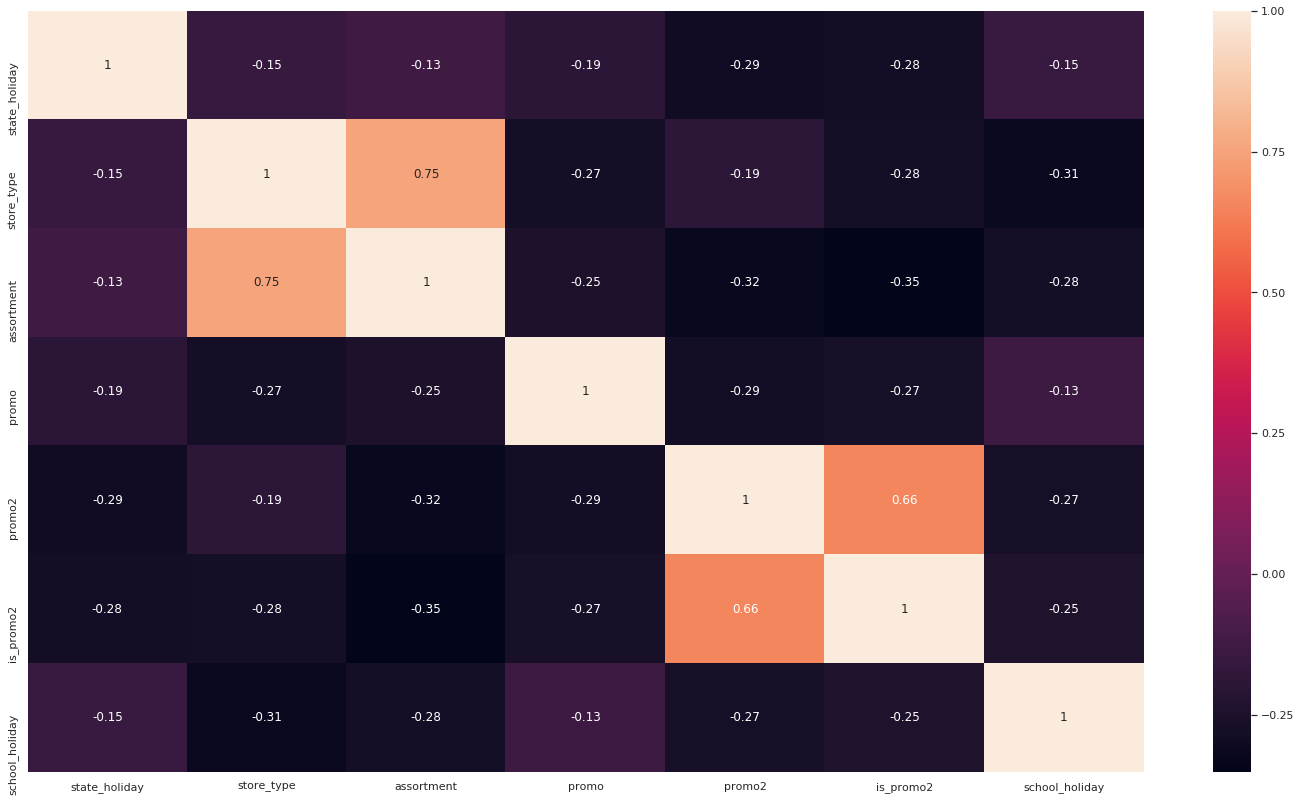

In [203]:
sns.heatmap(cramer_tab.corr(method='pearson'),annot=True)

- Observou-se uma boa correlação entre as variáveis 'assortment' e 'store_type', que pode ser comprovada logicamente pois as duas estão relacionadas com o tipo/nível da loja; e também entre as variáveis 'promo2' e 'is_promo2' que se dá por estarem naturalemnte relaciondas.

# 5.0. PASSO 05 -  DATA PREPARATION

In [204]:
df5 = df4.copy()

## 5.1 - Rescaling

In [206]:
#competition_distance - bastante outlier

rs = RobustScaler()
mms = MinMaxScaler()

df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl', 'wb'))

#competition_time_month - bastante outlier

df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl', 'wb'))

#promo_time_week 

df5['promo2_time_week'] = mms.fit_transform(df5[['promo2_time_week']])
pickle.dump(mms, open('parameter/promo_time_week_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']])
pickle.dump(mms, open('parameter/year_scaler.pkl', 'wb'))

## 5.2 - Encoding

In [207]:
#state_holiday
df5 = pd.get_dummies(df5, prefix='state_holiday',columns=['state_holiday'])

#store_type
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5[['store_type']])
pickle.dump(le, open('parameter/store_type_encoding.pkl', 'wb'))

#assortment
dic =  {'basic': 1,'extended':2, 'extra':3}
df5['assortment'] = df5['assortment'].map(dic)


/home/brunnaneri/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## 5.3 - Transformação


### 5.3.1 - Transformação de Grandeza

In [208]:
df5['sales'] = np.log1p(df5['sales'])

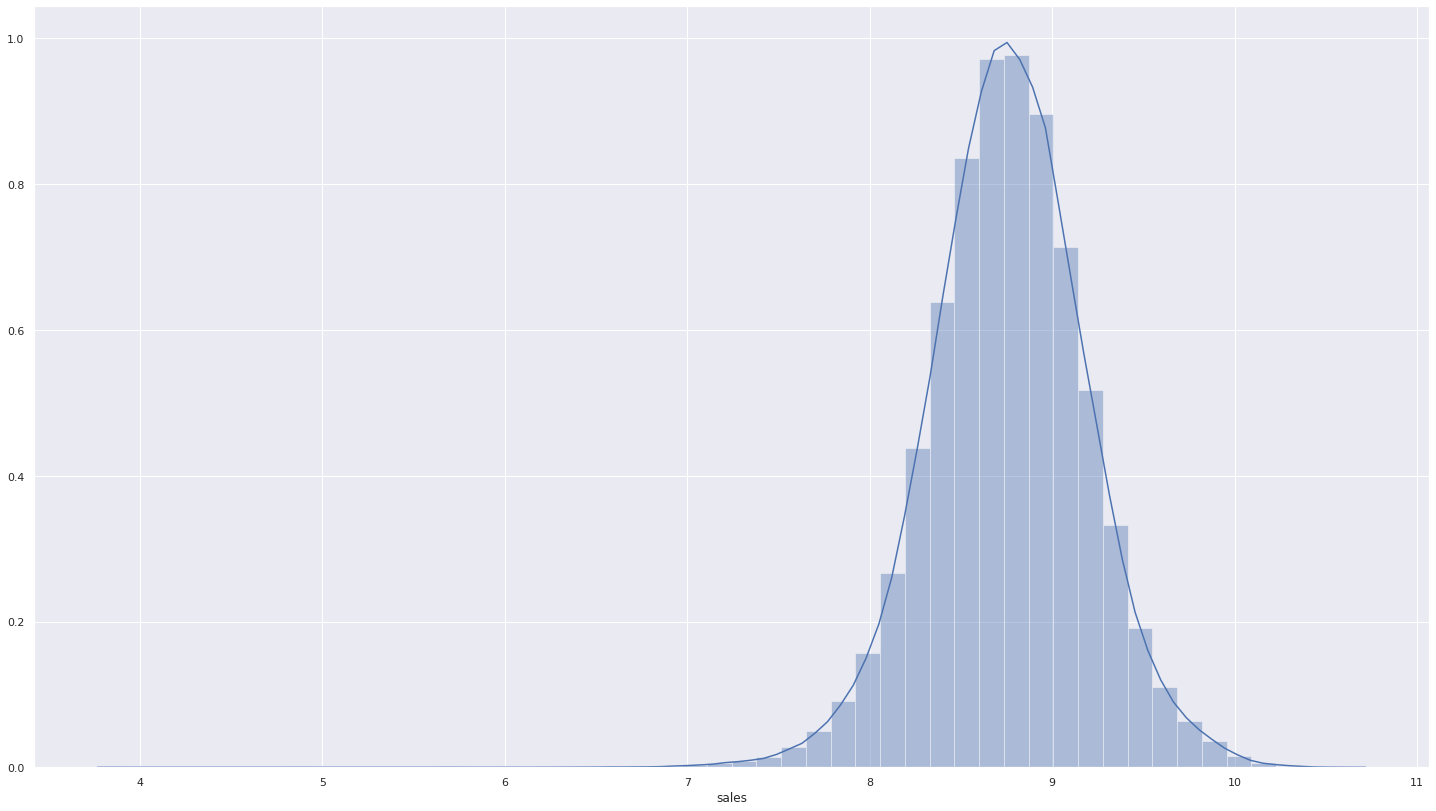

In [209]:
sns.distplot(df5['sales'])

### 5.3.2 - Transformações de Natureza

In [210]:
#day_of_week

df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin(x*(np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(np.pi/7)))

#month
df5['month_sen'] = df5['month'].apply(lambda x: np.sin(x*(np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(np.pi/12)))

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(np.pi/30)))

#week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(np.pi/52)))


# 6.0. PASSO 06 -  FEATURE SELECTION

In [214]:
df6 = df5.copy()

## 6.1 - Split dataframe into training and test dataset

In [216]:
cols_drop = ['month','week_of_year','day','day_of_week','promo2_since','competition_since','year_week']

df6 = df6.drop(cols_drop, axis=1)

In [217]:
#Data que inicia o período separado para ser usado como teste

df6[['date','store']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=42)

Timestamp('2015-06-19 00:00:00')

In [218]:
#Dados de treino

X_train = df6.loc[df6['date']<'2015-06-19']
y_train = X_train['sales']

#Dados de teste

X_test = df6.loc[df6['date']>='2015-06-19']
y_test = X_test['sales']


## 6.2 - Boruta as feature selector

- O algoritmo Boruta faz uma seleção das features que considera mais relevantes, as quais serão consideradas para serem utilizadas no modelo.

In [ ]:
##X_train_n
#
#cols_drop = ['date','sales']
#X_train_n = X_train.drop(cols_drop,axis=1).values
#
##Y_train_n
#
#y_train_n = y_train.values.ravel()
#
##RandomForestRegressor
#
#rf = RandomForestRegressor(n_jobs=-1)
#
##BorutaPy
#
#feat_selector = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=1).fit(X_train_n,y_train_n)



In [ ]:
#feature_selected = feat_selector.support_

In [ ]:
#feature_selected

In [ ]:
#X_train_fs = X_train.drop(cols_drop,axis=1)
#y_train_fs = y_train

In [ ]:
#cols_selected_boruta = X_train_fs.iloc[:,feature_selected].columns.to_list()

In [ ]:
#cols_selected_boruta

In [ ]:
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

In [ ]:
#cols_not_selected_boruta

## 6.3 - Manual Feature Selection

In [219]:
cols_selected_boruta = ['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo2_time_week',
 'day_of_week_sen',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos'
]

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )


# 7.0. PASSO 07 -  MACHINE LEARNING MODEL

- Os modelos de Machine Learning serão treinados considerando apenas as features selecionados na etapa de Feature Selection.
- Inicialmente os modelos foram treinados utilizando todos os dados de treino separados ateriomente, na etapa de feature selection, e em seguida foram treinados novamente utilizando a técnica de Cross-Validation (CV).
- A função de Cross-Validation foi desenvolvida manualmente e está disposta na sessão 0.1HELPER FUNCTION.
- A técnica de Cross-Validation permite medir o desempenho do modelo em vários intervalos de tempo no conjunto de dados total, de forma que permite diminuir a influência do período escolhido para realizar treinamento e teste.

In [220]:
#Dados de treino
x_train = X_train[cols_selected_boruta]
y_train = y_train

#Dados de teste
x_test = X_test[cols_selected_boruta]
y_test = y_test

#Time series data preparation to CV
xtraining = X_train[cols_selected_boruta_full]


## 7.1 - Average Model

- Modelo considerado como baseline que serve como referência comparativa para que se possa medir a qualidade dos modelos de Machine Learning treinados.

In [255]:
#model and prediction
prediction = X_test[['sales','store']].groupby('store').mean().reset_index()
prediction = prediction.rename(columns = {'sales':'prediction_sales'})

y_real  = X_test[['sales','store']]

#performance
to_performance = pd.merge(y_real,prediction,how='left',on='store')

yhat = to_performance['prediction_sales']
y = to_performance['sales']

In [256]:
avg = ml_error('Average Model',np.expm1(y),np.expm1(yhat))
avg

,Name_Model,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 - Linear Regression Model

In [257]:
#model
lr = LinearRegression().fit(x_train,y_train)

#prediction
yhat = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression',np.expm1(y_test),np.expm1(yhat))
lr_result

,Name_Model,MAE,MAPE,RMSE
0,Linear Regression,1862.386337,0.293202,2655.269908


### 7.2.1 - Linear Regression Model - CV
*tempo de execução 6.50s*

In [227]:
lr_cv = cross_validation(xtraining,LinearRegression(),'Linear Regression',5)


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


In [229]:
lr_cv

,Name_Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.12+/-341.75,0.29+/-0.02,2971.27+/-519.47


## 7.3 - Linear Regression Regularized Model - Lasso

In [258]:
#model
lrr = Lasso(alpha=0.01).fit(x_train,y_train)

#prediction
yhat = lrr.predict(x_test)

#performance
lrr_result = ml_error('Lasso',np.expm1(y_test),np.expm1(yhat))
lrr_result

,Name_Model,MAE,MAPE,RMSE
0,Lasso,1896.790622,0.289654,2749.113591


### 7.3.1- Lasso - CV
*tempo de execução 5.86s*

In [232]:
lrr_cv = cross_validation(xtraining,lrr,'Lasso',5)
lrr_cv


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


,Name_Model,MAE CV,MAPE CV,RMSE CV
0,Lasso,2143.28+/-395.1,0.29+/-0.01,3090.02+/-577.04


## 7.4 - Random Forest Regressor Model

In [259]:
#model
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=2).fit(x_train,y_train)

#prediction
yhat = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor',np.expm1(y_test),np.expm1(yhat))
rf_result

,Name_Model,MAE,MAPE,RMSE
0,Random Forest Regressor,694.649487,0.104069,1024.258728


### 7.4.1 - Random Forest Regressor Model - CV
*tempo de execução 25m6s*

In [234]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=2)
rf_cv = cross_validation(xtraining,rf,'Random Forest Regressor',5)


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


In [235]:
rf_cv

,Name_Model,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,854.45+/-269.82,0.12+/-0.03,1288.03+/-417.62


## 7.5 - XGBoost Regressor

In [260]:
#model
xgb_model = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytree=0.9 ).fit( x_train, y_train )

#prediction

yhat = xgb_model.predict(x_test)

#performance

xgb_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat))
xgb_result

,Name_Model,MAE,MAPE,RMSE
0,XGBoost Regressor,879.265789,0.126879,1305.154484


### 7.5.1 - XGBoost Regressor - CV
*tempo de execução 16m14s*

In [237]:
xgb_model = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=100,
                                eta=0.01,
                                max_depth=10,
                                subsample=0.7,
                                colsample_bytree=0.9 )
xgb_cv = cross_validation(xtraining,xgb_model,'XGBoost Regressor',5)


KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5


## 7.6 - Compiled Model Results

### 7.6.1 - Machine Learning Models - Part. 1

In [264]:
models_error = pd.concat([lr_result,lrr_result,rf_result,xgb_result], axis=0).reset_index(drop='True')
models_error

,Name_Model,MAE,MAPE,RMSE
0,Linear Regression,1862.386337,0.293202,2655.269908
1,Lasso,1896.790622,0.289654,2749.113591
2,Random Forest Regressor,694.649487,0.104069,1024.258728
3,XGBoost Regressor,879.265789,0.126879,1305.154484


### 7.6.2 - Machine Learning Models - Part. 2 - Cross Validation 

In [265]:
models_error = pd.concat([lr_cv,lrr_cv,rf_cv,xgb_cv], axis=0).reset_index(drop='True')

In [266]:
models_error

,Name_Model,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.12+/-341.75,0.29+/-0.02,2971.27+/-519.47
1,Lasso,2143.28+/-395.1,0.29+/-0.01,3090.02+/-577.04
2,Random Forest Regressor,854.45+/-269.82,0.12+/-0.03,1288.03+/-417.62
3,XGBoost Regressor,984.61+/-177.97,0.14+/-0.02,1402.0+/-247.48


- Observou-se que o problema tem um certo nível de complexidade e modelos lineares não performam bem neste caso;
- Random Forest e XGBoost apresentaram bons e similares desempenhos;
- Mesmo o Random Forest Regressor tendo um desempenho acima do XGBoost, fatores como tempo de execução do algoritmo e espaço de memória do modelo também foram considerados na escolha do modelo, por isso, o XGBoost Regressor foi escolhido para seguir na solução deste problema de negócio.

# 8.0. PASSO 08 -  HYPERPARAMETER FINE TUNNING 

- Método Random Search escolhido para definir os melhores parâmetros a serem utilizados no modelo final.

## 8.1 Random Search

In [240]:
params = { 'n_estimators':[1500,1750,2000,2500,3000],
           'eta':[0.01,0.03],
           'max_depth':[2,5,7],
           'subsample':[0.3,0.5,0.7],
           'colsample_bytree':[0.3,0.7]
}

MAX_EVAL = 5

warnings.filterwarnings("ignore")

In [241]:
import random
xgb_errors = pd.DataFrame()
hp_list = pd.DataFrame()


for i in range(MAX_EVAL):
    hp = {k: random.sample(v,1)[0] for k,v in params.items()}
    hp_list = hp_list.append(hp,ignore_index=True)
    print(hp)
    xgb_model = xgb.XGBRegressor(  objective='reg:squarederror',
                                       n_estimators = hp['n_estimators'],
                                       eta = hp['eta'],
                                       max_depth = hp['max_depth'],
                                       subsample= hp['subsample'],
                                       colsample_bytree= hp['colsample_bytree'])
         
    xgb_cv = cross_validation(xtraining,xgb_model,'XGBoost Regressor',5)
    
    xgb_errors = xgb_errors.append(xgb_cv)
    print(xgb_errors)
    
    
xgb_errors    

{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
          Name_Model           MAE CV      MAPE CV          RMSE CV
0  XGBoost Regressor  877.34+/-137.92  0.12+/-0.01  1255.0+/-197.39
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.7}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
          Name_Model           MAE CV      MAPE CV           RMSE CV
0  XGBoost Regressor  877.34+/-137.92  0.12+/-0.01   1255.0+/-197.39
0  XGBoost Regressor  1318.49+/-155.7  0.18+/-0.01  1889.94+/-198.71
{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.7}

KFold Number: 1

KFold Number: 2

KFold Number: 3

KFold Number: 4

KFold Number: 5
          Name_Model           MAE CV      MAPE CV           RMSE CV
0  XGBoost Regressor  877.34+/-137.92  0.12+/-0.

,Name_Model,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,877.34+/-137.92,0.12+/-0.01,1255.0+/-197.39
0,XGBoost Regressor,1318.49+/-155.7,0.18+/-0.01,1889.94+/-198.71
0,XGBoost Regressor,844.75+/-152.62,0.12+/-0.01,1226.83+/-217.29
0,XGBoost Regressor,897.98+/-141.27,0.12+/-0.01,1284.86+/-201.52
0,XGBoost Regressor,984.61+/-177.97,0.14+/-0.02,1402.0+/-247.48


In [247]:
    XGB_erros_table = {'parameters': ["'n_estimators': 2000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7",
                                      "'n_estimators': 2500, 'eta': 0.01, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.7",
                                      "'n_estimators': 3000, 'eta': 0.01, 'max_depth': 7, 'subsample': 0.5, 'colsample_bytree': 0.7",
                                      "'n_estimators': 1750, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.3, 'colsample_bytree': 0.7",
                                      "'n_estimators': 1750, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3"],
                       'MAE': ['877.34+/-137.92',
                               '1318.49+/-155.7',
                               '844.75+/-152.62',
                               '897.98+/-141.27',
                               '984.61+/-177.97'],
                       'MAPE': ['0.12+/-0.01',
                               '0.18+/-0.01',
                               '0.12+/-0.01',
                               '0.12+/-0.01',
                               '0.14+/-0.02'],
                       'RMSE':['1255.0+/-197.39',
                               '1889.94+/-198.71',
                               '1226.83+/-217.29',
                               '1284.86+/-201.52',
                               '1402.0+/-247.48']                   
                       }

    print(tabulate(XGB_erros_table, headers = ['parameters','MAE','MAPE','RMSE'], tablefmt='fancy_grid'))

╒══════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════╤═════════════╤══════════════════╕
│ parameters                                                                                   │ MAE             │ MAPE        │ RMSE             │
╞══════════════════════════════════════════════════════════════════════════════════════════════╪═════════════════╪═════════════╪══════════════════╡
│ 'n_estimators': 2000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.7 │ 877.34+/-137.92 │ 0.12+/-0.01 │ 1255.0+/-197.39  │
├──────────────────────────────────────────────────────────────────────────────────────────────┼─────────────────┼─────────────┼──────────────────┤
│ 'n_estimators': 2500, 'eta': 0.01, 'max_depth': 2, 'subsample': 0.7, 'colsample_bytree': 0.7 │ 1318.49+/-155.7 │ 0.18+/-0.01 │ 1889.94+/-198.71 │
├──────────────────────────────────────────────────────────────────────────────────────────────┼────────────────

## 8.1 Final Model - NÃO É PRECISO RODAR

- Modelo que será treinado com todos o dados disponíveis para treino, utilizando os paramêtros eleitos por melhor desempenho. 

In [249]:
param_tuned = {'n_estimators': 1750, 
                'eta': 0.03, 
                'max_depth': 5, 
                'subsample': 0.3, 
               'colsample_bytree': 0.7}

In [250]:
#model
xgb_model_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                n_estimators=param_tuned['n_estimators'],
                                eta=param_tuned['eta'],
                                max_depth=param_tuned['max_depth'],
                                subsample=param_tuned['subsample'],
                                colsample_bytree=param_tuned['colsample_bytree'] ).fit( x_train, y_train )

#prediction

yhat_tuned = xgb_model_tuned.predict(x_test)

#performance

xgb_tuned_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_tuned))
xgb_tuned_result

,Name_Model,MAE,MAPE,RMSE
0,XGBoost Regressor,685.688619,0.101687,988.820648


In [ ]:
#Saving model 
#pickle.dump(xgb_model_tuned, open('model/model_rossmann.pkl','wb'))

In [280]:
#Loading model

pickled_model = pickle.load(open('model/model_rossmann.pkl', 'rb'))

yhat_tuned = pickled_model.predict(x_test)
xgb_tuned_result = ml_error('XGBoost Regressor',np.expm1(y_test),np.expm1(yhat_tuned))
xgb_tuned_result

,Name_Model,MAE,MAPE,RMSE
0,XGBoost Regressor,685.688619,0.101687,988.820648


# 9.0. PASSO 09 -  INTERPRETAÇÃO E TRADUÇÃO DO ERRO

In [268]:
df9 = X_test[cols_selected_boruta_full]
df9['sales'] = np.expm1(df9['sales'])
df9['prediction'] = np.expm1(yhat_tuned)

## 9.1 - Business Performance

- Traduzir a performance do modelo para resultado financeiro, considerando diferentes cenários.

In [269]:
#Group by store
df91 = df9[['store','prediction']].groupby('store').sum().reset_index()

#MAE per store
mae = df9[['sales','store','prediction']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['prediction'])).reset_index().rename({0: 'MAE'},axis =1)

#MAPE per store
mape = df9[['sales','store','prediction']].groupby('store').apply(lambda x: mean_absolute_percentual_error(x['sales'], x['prediction'])).reset_index().rename({0: 'MAPE'},axis =1)

#Merge errors
df_aux = pd.merge(mae,mape,how='inner',on='store')
df92 = pd.merge(df91,df_aux, how = 'inner',on='store')

#Scenarios
df92['worst_scenario'] = df92['prediction'] - df92['MAE']
df92['best_scenario'] = df92['prediction']  + df92['MAE']

In [271]:
df92.head()

,store,prediction,MAE,MAPE,worst_scenario,best_scenario
0,1,161278.609375,275.730621,0.062825,161002.878754,161554.339996
1,2,182446.890625,396.693313,0.081775,182050.197312,182843.583938
2,3,262568.281250,566.920126,0.079047,262001.361124,263135.201376
3,4,348689.750000,861.404574,0.082938,347828.345426,349551.154574
4,5,173324.593750,387.789676,0.084827,172936.804074,173712.383426


In [272]:
df92.sort_values(by='MAPE', ascending=False).head()

,store,prediction,MAE,MAPE,worst_scenario,best_scenario
291,292,106575.789062,3393.871800,0.591379,103181.917262,109969.660863
908,909,232991.250000,7810.001019,0.531881,225181.248981,240801.251019
875,876,200172.203125,3962.670962,0.305380,196209.532163,204134.874087
594,595,379043.593750,4058.632337,0.278135,374984.961413,383102.226087
721,722,349444.062500,1896.407939,0.249816,347547.654561,351340.470439


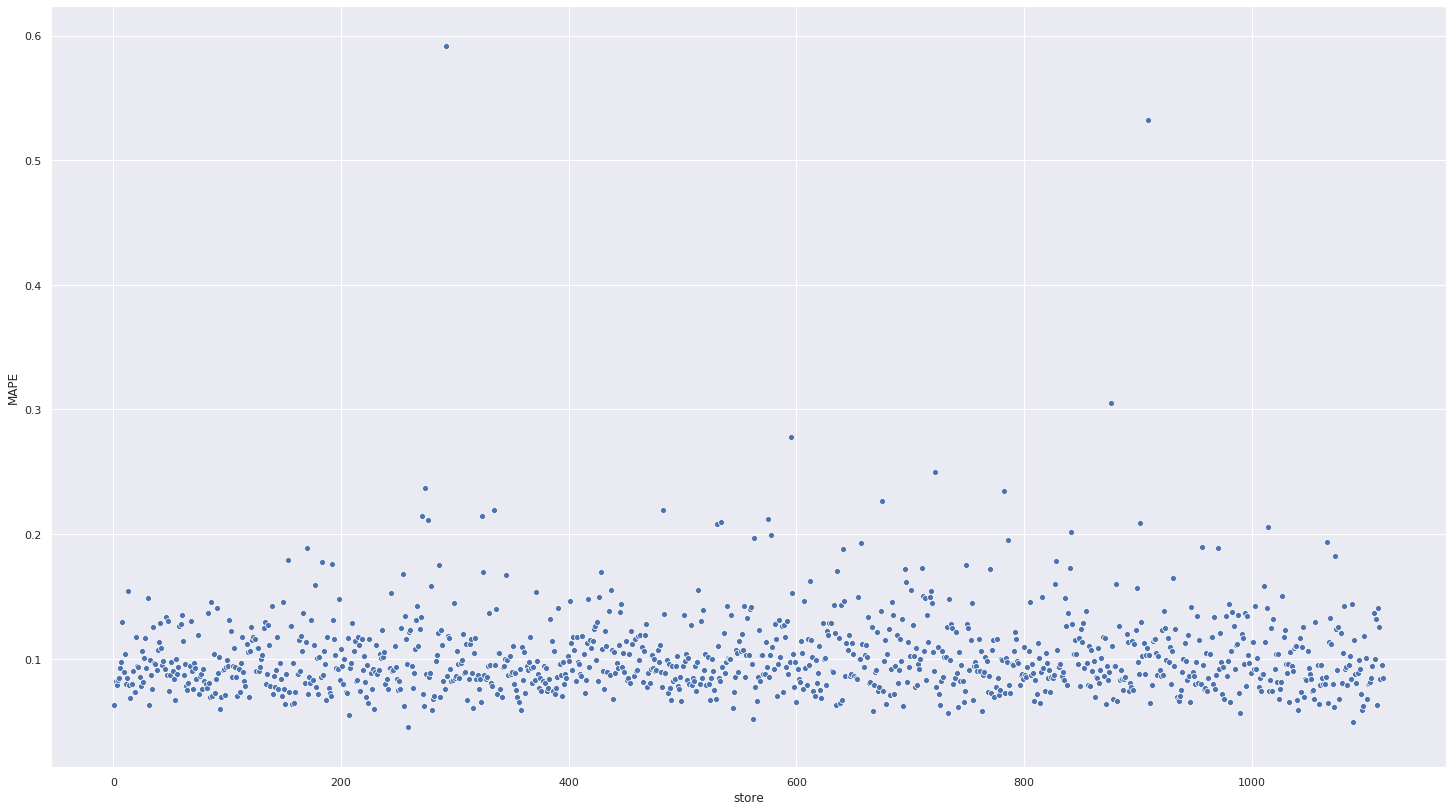

In [273]:
sns.scatterplot(data=df92, x="store", y="MAPE")

## 9.2 - Total Performance

In [274]:
total_performance = df92[['prediction','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename({'index':'scenarios',0: 'values'},axis=1)
total_performance['values'] = total_performance['values'].apply('R${:,.2f}'.format)

In [275]:
total_performance

,scenarios,values
0,prediction,"R$286,570,592.00"
1,worst_scenario,"R$285,802,068.49"
2,best_scenario,"R$287,339,116.71"


## 9.3 - Machine Learning Performance

In [276]:
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo2_time_week,day_of_week_sen,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,prediction
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,0.781831,-0.62349,-0.104528,-0.994522,0.954721,-0.297503,2015-07-31,5263.0,5159.073242
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,0.781831,-0.62349,-0.104528,-0.994522,0.954721,-0.297503,2015-07-31,6064.0,6137.729004
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,0.781831,-0.62349,-0.104528,-0.994522,0.954721,-0.297503,2015-07-31,8314.0,9849.741211
3,4,1,2,2,-0.275806,9,2009,0,31,2015,0.743243,0.287016,0.781831,-0.62349,-0.104528,-0.994522,0.954721,-0.297503,2015-07-31,13995.0,12144.182617
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,0.781831,-0.62349,-0.104528,-0.994522,0.954721,-0.297503,2015-07-31,4822.0,6548.123535


In [277]:
#Error
df9['error'] = df9['sales'] - df9['prediction']

#Error rate
df9['error_rate'] = df9['prediction'] / df9['sales']

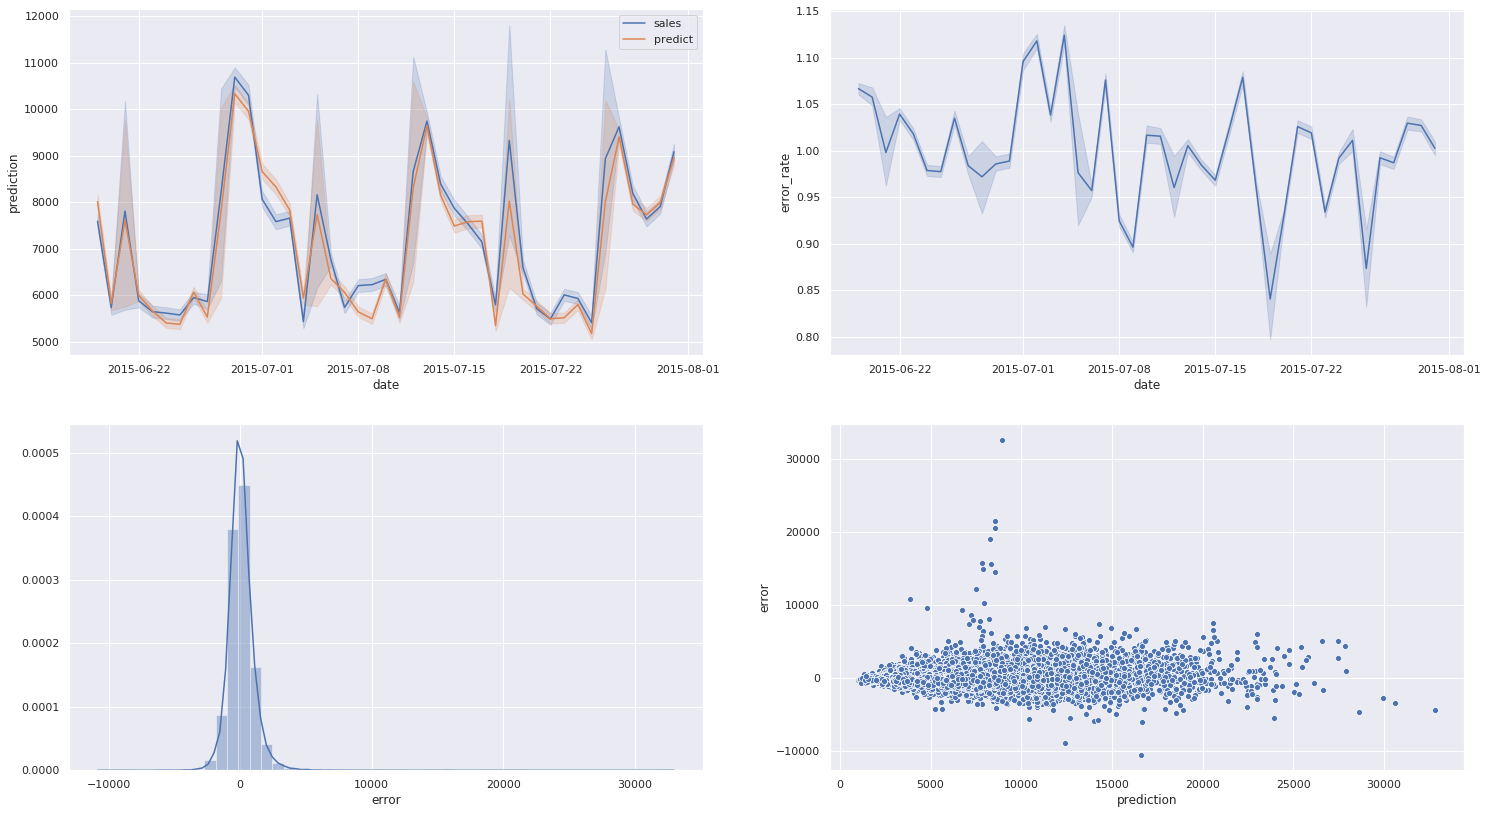

In [279]:
#Plots

plt.subplot(2,2,1)
sns.lineplot(data=df9, x="date", y="sales",label='sales')
sns.lineplot(data=df9, x="date", y="prediction", label='predict')

plt.subplot(2,2,2)
sns.lineplot(data=df9, x="date", y="error_rate")

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(data=df9, x='prediction',y='error')


# 10.0. PASSO 10 -  DEPLOY MODEL TO PRODUCTION

## 10.1 - Rossmann Class

In [255]:
import pandas as pd
import numpy  as np

import math
import pickle
import datetime
import inflection


class Rossmann(object):
    def __init__(self):
        self_path = '/home/brunnaneri/repos/ds-em-producao/'
        self.competition_distance_scaler   = pickle.load(open(self_path + 'parameter/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open(self_path + 'parameter/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open(self_path + 'parameter/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open(self_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_encoding           = pickle.load(open(self_path + 'parameter/store_type_encoding.pkl', 'rb'))
        
    def data_cleaning(self,df1):
        old_columns = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']
        snake_case = lambda x : inflection.underscore(x)
        new_columns = list(map(snake_case,old_columns))
        #Rename Columns
        df1.columns = new_columns
        
        ## 1.3 Data Types
        #date to datetime
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        #competition_distance   
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)
        
        #competition_open_since_month    
        df1['competition_open_since_month'] = df1.apply(lambda x : x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'],axis=1)
        
        #competition_open_since_year     
        df1['competition_open_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)             
        
        #promo2_since_week    
        df1['promo2_since_week'] = df1.apply(lambda x : x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis=1)
        
        #promo2_since_year               
        df1['promo2_since_year'] = df1.apply(lambda x : x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'],axis=1)
        
        #promo_interval                  
        df1['promo_interval'].fillna(0,inplace=True)     
                  
        dic_month = {1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sept',10:'Oct',11:'Nov',12:'Dec'}
        df1['month_of_date'] = df1['date'].dt.month.map(dic_month)
        df1['is_promo2'] = df1[['promo_interval','month_of_date']].apply(lambda x : 0 if x['promo_interval'] == 0 else 1 if x['month_of_date'] in x['promo_interval'].split(',') else 0, axis =1)
        
        ## 1.6 Change Types
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
        #year
        df2['year']=df2['date'].dt.year
        
        #month
        df2['month']=df2['date'].dt.month
        
        #week
        df2['day']=df2['date'].dt.day
        
        #week of year
        df2['week_of_year'] = df2['date'].dt.weekofyear
        
        #year week
        df2['year_week'] = df2['date'].apply(lambda x: x.strftime('%Y-%W'))
        
        #competition since (unidade: mês)
        df2['competition_since'] = df2['competition_open_since_year'].astype(str) + '-'+ df2['competition_open_since_month'].astype(str)+'-1'
        df2['competition_since'] = df2['competition_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%d') )
        df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x: x.days).astype(int)
        
        ##promo since
        df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-'+ df2['promo2_since_week'].astype(str)+'-1'
        df2['promo2_since'] = (df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x,'%Y-%W-%w'))) - datetime.timedelta(days=7)
        df2['promo2_time_week'] = ((df2['date']-df2['promo2_since'])/7).apply(lambda x: x.days).astype(int)
        
        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x =='b' else 'extended')
        
        #state holiday
        
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x:'public_holiday' if x=='a' else 
                                                          'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')
        #Filtragem das linhas
        df2 = df2[(df2['open']!=0)]
        
        #Seleção das colunas
        cols_drop = ['open','month_of_date','promo_interval']
        df2 = df2.drop(cols_drop,axis=1)
        
        return df2
    
    def data_preparation(self,df5):
        
        #competition_distance - bastante outlier
        df5['competition_distance'] = self.competition_distance_scaler.transform(df5[['competition_distance']])
        
        #competition_time_month - bastante outlier
        df5['competition_time_month'] = self.competition_time_month_scaler.transform(df5[['competition_time_month']])
        
        #promo_time_week 
        df5['promo2_time_week'] = self.promo_time_week_scaler.transform(df5[['promo2_time_week']])
        
        #year
        df5['year'] = self.year_scaler.transform(df5[['year']])
        
        ## 5.2 - Encoding
        
        #state_holiday
        df5 = pd.get_dummies(df5, prefix='state_holiday',columns=['state_holiday'])
        
        #store_type
        df5['store_type'] = self.store_type_encoding.transform(df5[['store_type']])
        
        #assortment
        dic =  {'basic': 1,'extended':2, 'extra':3}
        df5['assortment'] = df5['assortment'].map(dic)
        
        ## 5.3 - Transformação
        
        ### 5.3.1 - Transformação de Grandeza
        
        #df5['sales'] = np.log1p(df5['sales'])
        
        ### 5.3.2 - Transformações de Natureza
        
        #day_of_week
        df5['day_of_week_sen'] = df5['day_of_week'].apply(lambda x: np.sin(x*(np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(np.pi/7)))
        
        #month
        df5['month_sen'] = df5['month'].apply(lambda x: np.sin(x*(np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(np.pi/12)))
        
        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(np.pi/30)))
        
        #week_of_year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(np.pi/52)))

        #colunas selecionadas
        cols_selected = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                                'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo2_time_week','day_of_week_sen','day_of_week_cos',
                                'day_sin','day_cos','week_of_year_sin','week_of_year_cos']

        return df5[cols_selected]
    
    def get_prediction(self,model,data_original,data_prepared):
        
        prediction = model.predict(data_prepared)
        data_original['prediction'] = np.expm1(prediction)

        return data_original.to_json(orient='records', date_format='iso')
    

## 10.2 - Handler API

In [ ]:
import pandas as pd
import pickle
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann


#loading model
model = pickle.load(open ('home/brunnaneri/repos/ds-em-producao/model/model_rossmann.pkl','rb'))

#inicialize API

app = Flask(__name__)
@app.route('/rossmann/predict',methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()
    if test_json: #there is data
        if isinstance(test_json, dict):
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else:
             test_raw = pd.DataFrame(test_json, columns = test_json[0].keys() )
        
        #Instantiate Rossmann Class
        pipeline = Rossmann()
        
        #Data Cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #Feature Engineering
        df2 = pipeline.feature_engineering(df1)
        
        #Data Preparation
        df3 = pipeline.data_preparation(df2)
        
        #Prediction
        df_response = pipeline.get_prediction(model,test_raw,df3)
        
        return df_response
    
    else:
        return Response('{}',status=200, minetype='application/json')

if __name__=="__main__":
    app.run('0.0.0.0')
    



## 10.1 - API Tester 

In [321]:
import requests
import pandas as pd

In [328]:
#loading dataset
df10 = pd.read_csv('data/test.csv', low_memory = False)

#merge datasets
df_test = pd.merge(df10,df_raw_store, how='left',on='Store')

#cleaning dataset
df_test = df_test.drop('Id', axis=1)
df_test = df_test[df_test['Open']!=0]
df_test = df_test[~df_test['Open'].isnull()]

#choose store to predict
df_test = df_test[df_test['Store']==22]

#DataFrame to Json
data = json.dumps(df_test.to_dict(orient='records'))

#Call API
#url = 'http://0.0.0.0:5000/rossmann/predict'
url = 'https://rossmann-app-model.herokuapp.com/rossmann/predict'
header = {"Content-Type": "application/json"}
data = data

r = requests.post(url, headers=header, data=data)

print('Status code {}'.format(r.status_code))


Status code 200


In [329]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()
print('Store Number {} will sell R${:,.2f} in the next 6 weeks.'.format(d2['store'][0],d2['prediction'][0]))

In [284]:
##Constants
#TOKEN = '5526399212:AAHIxlemiEqr7RUWPUBLl4xPIDYig9ZMJf0'
#
#def send_message(chat_id,text):
#    url = 'https://api.telegram.org/bot/{}'.format(TOKEN)
#    url = url + '/sendMessage?chat_id={}'.format(chat_id)
#    r = request.post(url, json={'text':text})
#    return None
#
#def parse_message(message):
#    chat_id = message['message']['chat']['id']
#    store_id = message['message']['text']
#    
#    #check store_id
#    try:
#        store_id = int(store_id)
#    except ValueError:
#        if store_id.lower() == 'start':
#            msg = 'Welcome to Rossmann's Sales Forecast Bot! Please, type "/" + the store number you want to know the sales forecast.'
#            send_message(chat_id, msg)
#
#        elif store_id.lower() == 'hi' or store_id.lower() == 'hello':
#            send_message(chat_id, 'Hello there! How are you?')
#
#        elif store_id.lower() == 'bye':
#            send_message(chat_id, 'Bye bye!')
#        else:
#            store_id = 'error'
#    
#    return chat_id, store_id
#
#def load_dataset(store_id):
#    #loading dataset
#    df10 = pd.read_csv('/home/brunnaneri/repos/ds-em-producao/data/test.csv', low_memory = False)
#    df_raw_store = pd.read_csv('/home/brunnaneri/repos/ds-em-producao/data/store.csv', low_memory = False)
#    
#    #merge datasets
#    df_test = pd.merge(df10,df_raw_store, how='left',on='Store')
#    
#    #cleaning dataset
#    df_test = df_test.drop('Id', axis=1)
#    df_test = df_test[df_test['Open']!=0]
#    df_test = df_test[~df_test['Open'].isnull()]
#    
#    #choose store to predict
#    df_test = df_test[df_test['Store']==store_id]
#    
#    if not df_test.empty: 
#        #DataFrame to Json
#        data = json.dumps(df_test.to_dict(orient='records'))
#    else: #data vazio: store_id não existe nos dados de teste
#        data = 'error'
#    
#    return data
#
#def predict(data):
#    #Call API
#    url = 'https://rossmann-app-model.herokuapp.com/rossmann/predict'
#    header = {"Content-Type": "application/json"}
#    data = data
#    r = requests.post(url, headers=header, data=data)
#    d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
#    
#    return d1
#
##Inicialize API
#
#app = Flask(__name__)
#@app.route('/',methods=['POST','GET'])
#
#def index():
#    if request.method=='POST':
#        message = request.get_json()
#        chat_id, store_id = parse_message(message)
#        
#        if store_id != 'error':
#            #load dataset
#            data = load_dataset(store_id)
#            if data != 'error':
#                #predict
#                d1 = predict(data)
#                
#                #pred per store
#                d2 = d1[['store','prediction']].groupby('store').sum().reset_index()
#                
#                #result
#                msg = 'Store Number {} will sell R${:,.2f} in the next 6 weeks.'.format(d2['store'][0],d2['prediction'][0])
#                send_message(chat_id, msg)
#                return Response('OK', status = 200)
#            
#            else:
#                send_message(chat_id, 'Esta loja não está disponível!')
#                return Response('OK', status = 200)
#        else:
#            send_message(chat_id, 'Store ID deve ser um número!')
#        
#            return Response('OK', status = 200)
#    
#    else:
#        return '<h1> Rossmann Telegram Bot </h1>'  
#